# Objetivo

Entender as relações entre as variáveis explicativas e as explicativas e a resposta. A ideia inicial é utilizar o pagamento como variável resposta.

# Pacotes e funções

In [1]:
import pandas as pd
import os
from scipy.stats import chi2_contingency
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
import pickle

In [2]:
%run ../99.Funcoes_auxiliares/Funcoes.py

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Leitura da base de treino

In [4]:
dados_full = pd.read_parquet('../0.Avalia_Dados/Dados/treino.parquet')

In [5]:
# Colunas desconsideradas: id, documento, mes_pagamento, divida_restante, per_pago, genero
# Colunas desconsideradas momentaneamente para o problema de regressão: target

colunas_remove = ['id', 'documento', 'mes_pagamento', 'divida_restante', 'per_pago', 'GENERO', 'target']

dados_full.drop(columns=colunas_remove, inplace=True)

# Removendo duplicatas, se houver
dados_full.drop_duplicates(inplace=True)

In [7]:
dados_full.shape

(109840, 249)

In [8]:
dados_full.head(3)

dias_atraso segmento_veiculo  saldo_vencido  pagamento   IDADE    UF  \
index                                                                         
7               13            leves         361.51     361.51  25.173  UF_0   
8               11            leves         873.51     873.51  23.767  UF_7   
17              19            leves        1242.81    1242.81  47.268  UF_8   

      VAR_1 VAR_2      VAR_3  VAR_4  VAR_5  VAR_7  VAR_8     VAR_9    VAR_11  \
index                                                                          
7         E     E  ALTISSIMA    0.0  0.051    NaN    NaN  1.333333       NaN   
8      None     E       ALTA    NaN  0.101    NaN    NaN  1.083333       NaN   
17        E     E      MEDIA    0.0  0.057  0.626  0.708  1.500000  2.471023   

        VAR_12  VAR_15  VAR_17  VAR_18  VAR_21  VAR_22  VAR_23  \
index                                                            
7          NaN     NaN     NaN     NaN     NaN   0.086     NaN   
8          NaN     NaN     NaN     NaN   0.029   0.180     0.0   
17     7.40625   0.124   0.054     0.0     NaN   0.031     NaN   

                       VAR_25    VAR_32    VAR_33    VAR_34    VAR_35  VAR_40  \
index                                                                           
7                        None  0.150710  0.468842  0.706907  0.053589   0.000   
8                        None  0.443021  0.417956  0.520832  0.476766   0.643   
17     DECLARACAO NAO ENVIADA  0.496317  0.412051  0.407311       NaN   0.000   

      VAR_42 VAR_43 VAR_44 VAR_45 VAR_46 VAR_47 VAR_48 VAR_49 VAR_50 VAR_51  \
index                                                                         
7       None   None   None   None   None   None   None   None   None   None   
8          S      N      N      N      N      N      N      S      N      N   
17      None   None   None   None   None   None   None   None   None   None   

      VAR_52 VAR_53 VAR_54 VAR_55 VAR_56 VAR_57 VAR_58     VAR_59      VAR_60  \
index                                                                           
7       None   None   None   None   None   None   None      MEDIA  BAIXISSIMA   
8          N      N      N      N      S      N      N  ALTISSIMA  BAIXISSIMA   
17      None   None   None   None   None   None   None      MEDIA  BAIXISSIMA   

           VAR_61 VAR_62      VAR_63      VAR_64      VAR_65      VAR_66  \
index                                                                      
7      BAIXISSIMA   ALTA  BAIXISSIMA  BAIXISSIMA       MEDIA  BAIXISSIMA   
8       ALTISSIMA   ALTA   ALTISSIMA        ALTA   ALTISSIMA        ALTA   
17     BAIXISSIMA  MEDIA       MEDIA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   

           VAR_67      VAR_68      VAR_69      VAR_70      VAR_71      VAR_72  \
index                                                                           
7      BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8       ALTISSIMA        ALTA   ALTISSIMA   ALTISSIMA   ALTISSIMA   ALTISSIMA   
17          MEDIA       MEDIA        ALTA  BAIXISSIMA  BAIXISSIMA       MEDIA   

           VAR_73 VAR_74      VAR_75      VAR_76      VAR_77      VAR_78  \
index                                                                      
7      BAIXISSIMA  BAIXA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8           MEDIA   ALTA        ALTA   ALTISSIMA   ALTISSIMA        ALTA   
17          MEDIA  MEDIA   ALTISSIMA  BAIXISSIMA        ALTA  BAIXISSIMA   

           VAR_79 VAR_80     VAR_81      VAR_82      VAR_83      VAR_84  \
index                                                                     
7      BAIXISSIMA  MEDIA      BAIXA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8            ALTA   ALTA  ALTISSIMA   ALTISSIMA  BAIXISSIMA        ALTA   
17          MEDIA  BAIXA      MEDIA       MEDIA  BAIXISSIMA       BAIXA   

          VAR_85      VAR_86      VAR_87      VAR_88      VAR_89      VAR_90  \
index                                          

# Exploração das variáveis categóricas

In [9]:
# Somente as variáveis categóricas

dados_full.head().select_dtypes(include=['object']).columns

Index(['segmento_veiculo', 'UF', 'VAR_1', 'VAR_2', 'VAR_3', 'VAR_25', 'VAR_42',
       'VAR_43', 'VAR_44', 'VAR_45',
       ...
       'VAR_250', 'VAR_256', 'VAR_257', 'VAR_304', 'VAR_306', 'VAR_307',
       'VAR_308', 'VAR_311', 'VAR_312', 'VAR_314'],
      dtype='object', length=112)

In [5]:
# Para as variáveis categóricas sem informação, serão preenchidas com 'Sem_Info'

cat = dados_full.select_dtypes(include=['object'])
cat = cat.fillna('Sem_Info')
cat.head(3)

segmento_veiculo    UF     VAR_1 VAR_2      VAR_3  \
index                                                     
7                leves  UF_0         E     E  ALTISSIMA   
8                leves  UF_7  Sem_Info     E       ALTA   
17               leves  UF_8         E     E      MEDIA   

                       VAR_25    VAR_42    VAR_43    VAR_44    VAR_45  ...  \
index                                                                  ...   
7                    Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  ...   
8                    Sem_Info         S         N         N         N  ...   
17     DECLARACAO NAO ENVIADA  Sem_Info  Sem_Info  Sem_Info  Sem_Info  ...   

        VAR_250 VAR_256   VAR_257      VAR_304  VAR_306  VAR_307  VAR_308  \
index                                                                       
7      Sem_Info       N  Sem_Info  MUITO LONGE  PROXIMO  PROXIMO  PROXIMO   
8      Sem_Info       N  Sem_Info        MEDIO  PROXIMO    LONGE    MEDIO   
17            S       N         N        MEDIO  PROXIMO  PROXIMO  PROXIMO   

      VAR_311  VAR_312 VAR_314  
index                           
7      URBANO  SUDESTE       F  
8      URBANO      SUL       F  
17     URBANO  SUDESTE       D  

[3 rows x 112 columns]

In [11]:
cat.shape

(109840, 112)

In [12]:
# Categóricas nominais

cat[['segmento_veiculo', 'UF', 'VAR_25', 'VAR_311', 'VAR_312', 'VAR_42', 'VAR_43', 'VAR_44', 'VAR_45', 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_49', 'VAR_50', 'VAR_51', 
     'VAR_52', 'VAR_53', 'VAR_54', 'VAR_55', 'VAR_56', 'VAR_57', 'VAR_58', 'VAR_233', 'VAR_238', 'VAR_240', 'VAR_250', 'VAR_256', 'VAR_257']].head()

segmento_veiculo     UF                  VAR_25 VAR_311   VAR_312  \
index                                                                     
7                leves   UF_0                Sem_Info  URBANO   SUDESTE   
8                leves   UF_7                Sem_Info  URBANO       SUL   
17               leves   UF_8  DECLARACAO NAO ENVIADA  URBANO   SUDESTE   
19               leves  UF_12                Sem_Info  URBANO  NORDESTE   
27               leves  UF_21  DECLARACAO NAO ENVIADA  URBANO   SUDESTE   

         VAR_42    VAR_43    VAR_44    VAR_45    VAR_46    VAR_47    VAR_48  \
index                                                                         
7      Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
8             S         N         N         N         N         N         N   
17     Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
19            S         S         N         N         N         N         N   
27            S         N         N         N         S         N         N   

         VAR_49    VAR_50    VAR_51    VAR_52    VAR_53    VAR_54    VAR_55  \
index                                                                         
7      Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
8             S         N         N         N         N         N         N   
17     Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
19            N         N         N         S         N         N         N   
27            N         N         N         N         N         N         N   

         VAR_56    VAR_57    VAR_58   VAR_233   VAR_238   VAR_240   VAR_250  \
index                                                                         
7      Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
8             S         N         N  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
17     Sem_Info  Sem_Info  Sem_Info         S         N         N         S   
19            N         N         N  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
27            N         N         N         S         N         N         S   

      VAR_256   VAR_257  
index                    
7           N  Sem_Info  
8           N  Sem_Info  
17          N         N  
19          N  Sem_Info  
27          N         N

In [13]:
# Categóricas ordinais 1

cat[['VAR_1', 'VAR_2', 'VAR_314', 'VAR_135', 'VAR_3', 'VAR_59', 'VAR_60', 'VAR_61', 'VAR_62', 'VAR_63', 'VAR_64', 'VAR_65', 'VAR_66', 'VAR_67', 'VAR_68', 'VAR_69', 'VAR_70', 
     'VAR_71', 'VAR_72', 'VAR_73', 'VAR_74', 'VAR_75', 'VAR_76', 'VAR_77', 'VAR_78', 'VAR_79', 'VAR_80', 'VAR_81', 'VAR_82', 'VAR_83', 'VAR_84', 
     'VAR_85', 'VAR_86', 'VAR_87', 'VAR_88', 'VAR_89', 'VAR_90', 'VAR_91', 'VAR_92', 'VAR_93', 'VAR_94']].head()

VAR_1 VAR_2 VAR_314 VAR_135      VAR_3      VAR_59      VAR_60  \
index                                                                      
7             E     E       F       E  ALTISSIMA       MEDIA  BAIXISSIMA   
8      Sem_Info     E       F       E       ALTA   ALTISSIMA  BAIXISSIMA   
17            E     E       D       E      MEDIA       MEDIA  BAIXISSIMA   
19     Sem_Info     E       F       E  ALTISSIMA  BAIXISSIMA  BAIXISSIMA   
27            E     E       A       E  ALTISSIMA       MEDIA        ALTA   

           VAR_61      VAR_62      VAR_63      VAR_64      VAR_65      VAR_66  \
index                                                                           
7      BAIXISSIMA        ALTA  BAIXISSIMA  BAIXISSIMA       MEDIA  BAIXISSIMA   
8       ALTISSIMA        ALTA   ALTISSIMA        ALTA   ALTISSIMA        ALTA   
17     BAIXISSIMA       MEDIA       MEDIA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
19     BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
27          MEDIA   ALTISSIMA       MEDIA       MEDIA  BAIXISSIMA       MEDIA   

           VAR_67      VAR_68      VAR_69      VAR_70      VAR_71      VAR_72  \
index                                                                           
7      BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8       ALTISSIMA        ALTA   ALTISSIMA   ALTISSIMA   ALTISSIMA   ALTISSIMA   
17          MEDIA       MEDIA        ALTA  BAIXISSIMA  BAIXISSIMA       MEDIA   
19     BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
27          MEDIA       MEDIA        ALTA  BAIXISSIMA       MEDIA  BAIXISSIMA   

           VAR_73 VAR_74      VAR_75      VAR_76      VAR_77      VAR_78  \
index                                                                      
7      BAIXISSIMA  BAIXA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8           MEDIA   ALTA        ALTA   ALTISSIMA   ALTISSIMA        ALTA   
17          MEDIA  MEDIA   ALTISSIMA  BAIXISSIMA        ALTA  BAIXISSIMA   
19     BAIXISSIMA  MEDIA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
27     BAIXISSIMA   ALTA        ALTA       MEDIA  BAIXISSIMA        ALTA   

           VAR_79      VAR_80      VAR_81      VAR_82      VAR_83      VAR_84  \
index                                                                           
7      BAIXISSIMA       MEDIA       BAIXA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8            ALTA        ALTA   ALTISSIMA   ALTISSIMA  BAIXISSIMA        ALTA   
17          MEDIA       BAIXA       MEDIA       MEDIA  BAIXISSIMA       BAIXA   
19     BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
27          MEDIA       MEDIA       MEDIA       MEDIA  BAIXISSIMA       MEDIA   

           VAR_85      VAR_86      VAR_87      VAR_88      VAR_89      VAR_90  \
index                                                                           
7           MEDIA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA   
8       ALTISSIMA   ALTISSIMA        ALTA        ALTA        ALTA        ALTA   
17           ALTA  BAIXISSIMA  BAIXISSIMA        ALTA       MEDIA       MEDIA   
19     BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA       BAIXA  BAIXISSIMA   
27          MEDIA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA        ALTA   ALTISSIMA   

           VAR_91      VAR_92      VAR_93      VAR_94  
index                                                  
7      BAIXISSIMA       BAIXA  BAIXISSIMA  BAIXISSIMA  
8       ALTISSIMA   ALTISSIMA  BAIXISSIMA   ALTISSIMA  
17          MEDIA       BAIXA   ALTISSIMA  BAIXISSIMA  
19     BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  BAIXISSIMA  
27          MEDIA       MEDIA  BAIXISSIMA       MEDIA

In [14]:
# Categóricas ordinais 2

cat[['VAR_95', 'VAR_96', 'VAR_97', 'VAR_98', 'VAR_99', 'VAR_100', 'VAR_101', 'VAR_102', 'VAR_103', 'VAR_104', 'VAR_105', 'VAR_106', 'VAR_107', 'VAR_108', 
     'VAR_109', 'VAR_110', 'VAR_111', 'VAR_112', 'VAR_113', 'VAR_114', 'VAR_115', 'VAR_116', 'VAR_117', 'VAR_118', 'VAR_119', 'VAR_120', 'VAR_121', 
     'VAR_122', 'VAR_123', 'VAR_124', 'VAR_125', 'VAR_126', 'VAR_127', 'VAR_128', 'VAR_129', 'VAR_130', 'VAR_131', 'VAR_132', 'VAR_133',
     'VAR_304', 'VAR_306', 'VAR_307', 'VAR_308']].head()

VAR_95       VAR_96       VAR_97         VAR_98       VAR_99  \
index                                                                      
7            LONGE  MUITO LONGE  MUITO LONGE    MUITO LONGE        LONGE   
8            MEDIO      PROXIMO        MEDIO          LONGE        LONGE   
17           LONGE      PROXIMO  MUITO LONGE  MUITO PROXIMO        MEDIO   
19     MUITO LONGE  MUITO LONGE  MUITO LONGE    MUITO LONGE  MUITO LONGE   
27           LONGE        LONGE        LONGE    MUITO LONGE        LONGE   

           VAR_100      VAR_101      VAR_102      VAR_103      VAR_104  \
index                                                                    
7            LONGE  MUITO LONGE        LONGE        LONGE  MUITO LONGE   
8            LONGE        MEDIO        MEDIO        LONGE      PROXIMO   
17           LONGE  MUITO LONGE        LONGE        LONGE        MEDIO   
19     MUITO LONGE  MUITO LONGE  MUITO LONGE  MUITO LONGE  MUITO LONGE   
27         PROXIMO  MUITO LONGE  MUITO LONGE        LONGE        LONGE   

           VAR_105      VAR_106      VAR_107      VAR_108        VAR_109  \
index                                                                      
7      MUITO LONGE  MUITO LONGE        LONGE  MUITO LONGE    MUITO LONGE   
8            MEDIO        MEDIO        LONGE        MEDIO          LONGE   
17           MEDIO        MEDIO        LONGE      PROXIMO          LONGE   
19     MUITO LONGE  MUITO LONGE  MUITO LONGE        LONGE  MUITO PROXIMO   
27           LONGE        LONGE  MUITO LONGE  MUITO LONGE  MUITO PROXIMO   

       VAR_110      VAR_111  VAR_112      VAR_113      VAR_114      VAR_115  \
index                                                                         
7        LONGE        LONGE  PROXIMO  MUITO LONGE        MEDIO  MUITO LONGE   
8        MEDIO        MEDIO    LONGE  MUITO LONGE        MEDIO        LONGE   
17     PROXIMO        MEDIO    MEDIO  MUITO LONGE        MEDIO        LONGE   
19       LONGE  MUITO LONGE  PROXIMO  MUITO LONGE  MUITO LONGE  MUITO LONGE   
27       LONGE  MUITO LONGE    MEDIO  MUITO LONGE  MUITO LONGE        LONGE   

           VAR_116      VAR_117      VAR_118      VAR_119      VAR_120  \
index                                                                    
7      MUITO LONGE        LONGE  MUITO LONGE  MUITO LONGE        LONGE   
8            MEDIO        MEDIO        MEDIO        MEDIO        MEDIO   
17           MEDIO        LONGE        MEDIO        LONGE        MEDIO   
19     MUITO LONGE  MUITO LONGE  MUITO LONGE  MUITO LONGE        LONGE   
27           LONGE        LONGE  MUITO LONGE        LONGE  MUITO LONGE   

             VAR_121      VAR_122      VAR_123      VAR_124        VAR_125  \
index                                                                        
7        MUITO LONGE        LONGE        LONGE  MUITO LONGE    MUITO LONGE   
8              MEDIO        LONGE        MEDIO        MEDIO          LONGE   
17             MEDIO        MEDIO        MEDIO        LONGE          MEDIO   
19       MUITO LONGE  MUITO LONGE  MUITO LONGE        LONGE  MUITO PROXIMO   
27     MUITO PROXIMO        LONGE  MUITO LONGE  MUITO LONGE  MUITO PROXIMO   

           VAR_126      VAR_127      VAR_128      VAR_129      VAR_130  \
index                                                                    
7      MUITO LONGE  MUITO LONGE        LONGE        LONGE        LONGE   
8            MEDIO        MEDIO        LONGE        MEDIO        MEDIO   
17         PROXIMO        LONGE        LONGE      PROXIMO        LONGE   
19     MUITO LONGE  MUITO LONGE  MUITO LONGE  MUITO LONGE  MUITO LONGE   
27           LONGE        LONGE  MUITO LONGE  MUITO LONGE        LONGE   

           VAR_131      VAR_132        VAR_133      VAR_304  VAR_306  VAR_307  \
index                                                                           
7            LONGE  MUITO LONGE  MUITO PROXIMO  MUITO LONGE  PROXIMO  PROXIMO   
8            MEDIO        MEDIO  MUITO PROXIM

In [6]:
# Tabelas de frequências das variáveis categóricas
    # Variáveis categóricas com mais de 85% dos valores concentrados em um nível serão desconsideradas: 
    # VAR_2, VAR_42, VAR_44, VAR_45, VAR_46, VAR_47, VAR_48, VAR_50, VAR_51, VAR_52, VAR_53, VAR_55, VAR_56, VAR_57, VAR_113, VAR_256

for i in cat.columns:
    print('===================================')
    print(i)
    print(conta_categorias(variavel=i, df = cat, dropna=True)[1])

segmento_veiculo
  segmento_veiculo      count
0            leves  70.698288
1            motos  29.301712
UF
          UF      count
0       UF_0  33.137291
1       UF_7   7.727604
2       UF_8   7.196832
3      UF_15   5.520757
4      UF_21   5.111981
5       UF_5   4.218864
6   Sem_Info   3.566096
7      UF_13   3.268390
8       UF_1   3.185543
9      UF_12   3.152768
10     UF_17   3.141843
11     UF_16   2.813183
12      UF_9   2.793154
13      UF_3   2.524581
14     UF_14   2.443554
15      UF_4   1.706118
16      UF_6   1.649672
17     UF_11   1.115259
18     UF_23   0.924071
19      UF_2   0.904953
20     UF_19   0.789330
21     UF_24   0.643664
22     UF_22   0.546249
23     UF_20   0.528041
24     UF_25   0.527130
25     UF_18   0.411508
26     UF_10   0.347779
27     UF_26   0.103787
VAR_1
      VAR_1      count
0         E  55.288602
1  Sem_Info  22.957939
2         D  16.558631
3         C   4.527495
4         B   0.462491
5         A   0.204843
VAR_2
      VAR_2      coun

In [7]:
# Aplicação do teste do qui-quadrado para verificar a independência entre as variáveis categóricas

colunas = cat.columns
colunas = colunas.drop(['VAR_2', 'VAR_42', 'VAR_44', 'VAR_45', 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_50', 'VAR_51', 'VAR_52', 'VAR_53', 'VAR_55', 'VAR_56', 'VAR_57', 'VAR_113', 'VAR_256'])

# Variáveis a serem retiradas por estarem correlacionadas

vars_retirar = []

for i in range(0,len(colunas)):
    for j in range(i+1,len(colunas)):
        
        # print(colunas[i], '+', colunas[j])

        # Variável auxiliar para a tabela de contingência
        aux = pd.crosstab(cat[colunas[i]], cat[colunas[j]], margins=True)
        
        # Teste do qui-quadrado: teste de independência
        chi, p, dof, expected = chi2_contingency(aux)
        # print(p)

        if p < 0.05:
            
            vars_retirar.append(colunas[j])
            print(colunas[i], '+', colunas[j])
            print('Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.')
            print('\n')
            print('====================================')

segmento_veiculo + UF
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_1
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_3
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_25
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_43
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_49
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_54
Rejeita H0, ou seja, não há evidência suficientes para afirmar que as variáveis são não correlacionadas.


segmento_veiculo + VAR_58
Rejeita H0, ou seja, não há evidência suficientes

In [8]:
# Variáveis que podem ser retiradas por estarem correlacionadas

vars_retirar = list(set(vars_retirar))
# vars_retirar

In [9]:
len(vars_retirar)

95

In [10]:
cat_new = cat.drop(columns=vars_retirar)
cat_new.head()

segmento_veiculo VAR_2    VAR_42    VAR_44    VAR_45    VAR_46  \
index                                                                  
7                leves     E  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
8                leves     E         S         N         N         N   
17               leves     E  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
19               leves     E         S         N         N         N   
27               leves     E         S         N         N         S   

         VAR_47    VAR_48    VAR_50    VAR_51    VAR_52    VAR_53    VAR_55  \
index                                                                         
7      Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
8             N         N         N         N         N         N         N   
17     Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info  Sem_Info   
19            N         N         N         N         S         N         N   
27            N         N         N         N         N         N         N   

         VAR_56    VAR_57      VAR_113 VAR_256  
index                                           
7      Sem_Info  Sem_Info  MUITO LONGE       N  
8             S         N  MUITO LONGE       N  
17     Sem_Info  Sem_Info  MUITO LONGE       N  
19            N         N  MUITO LONGE       N  
27            N         N  MUITO LONGE       N

In [11]:
for i in cat_new.columns:

    print(cat_new[i].unique())
    print('===================================')

['leves' 'motos']
['E' 'Sem_Info' 'C' 'D' 'B' 'A']
['Sem_Info' 'S' 'N']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'N' 'S']
['Sem_Info' 'S' 'N']
['Sem_Info' 'N' 'S']
['MUITO LONGE' 'PROXIMO' 'Sem_Info']
['N' 'Sem_Info']


In [12]:
DePara = {
    'leves': 0, 
    'motos': 1
}
cat_new['segmento_veiculo'] = cat_new['segmento_veiculo'].map(DePara)

In [13]:
DePara = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'Sem_Info': 5
}
cat_new['VAR_2'] = cat_new['VAR_2'].map(DePara)

In [14]:
DePara = {
    'Sem_Info': -1,
    'S': 1,
    'N': 0
}
# VAR_42	VAR_44	VAR_45	VAR_46	VAR_47	VAR_48	VAR_50	VAR_51	VAR_52	VAR_53	VAR_55	VAR_56	VAR_57
cat_new['VAR_42'] = cat_new['VAR_42'].map(DePara)
cat_new['VAR_44'] = cat_new['VAR_44'].map(DePara)
cat_new['VAR_45'] = cat_new['VAR_45'].map(DePara)
cat_new['VAR_46'] = cat_new['VAR_46'].map(DePara)
cat_new['VAR_47'] = cat_new['VAR_47'].map(DePara)
cat_new['VAR_48'] = cat_new['VAR_48'].map(DePara)
cat_new['VAR_50'] = cat_new['VAR_50'].map(DePara)
cat_new['VAR_51'] = cat_new['VAR_51'].map(DePara)
cat_new['VAR_52'] = cat_new['VAR_52'].map(DePara)
cat_new['VAR_53'] = cat_new['VAR_53'].map(DePara)
cat_new['VAR_55'] = cat_new['VAR_55'].map(DePara)
cat_new['VAR_56'] = cat_new['VAR_56'].map(DePara)
cat_new['VAR_57'] = cat_new['VAR_57'].map(DePara)
cat_new['VAR_256'] = cat_new['VAR_256'].map(DePara)

In [15]:
DePara = {
    'Sem_Info': -1,
    'MUITO LONGE': 1,
    'PROXIMO': 0
}
cat_new['VAR_113'] = cat_new['VAR_113'].map(DePara)

In [16]:
for i in cat_new.columns:

    print(cat_new[i].unique())
    print('===================================')

[0 1]
[4 5 2 3 1 0]
[-1  1  0]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  0  1]
[-1  1  0]
[-1  0  1]
[ 1  0 -1]
[ 0 -1]


# Exploração das variáveis numéricas

In [6]:
# Somente as variáveis numéricas

num = dados_full.select_dtypes(exclude=['object'])
num.head()

dias_atraso  saldo_vencido  pagamento   IDADE  VAR_4  VAR_5  VAR_7  \
index                                                                       
7               13         361.51     361.51  25.173    0.0  0.051    NaN   
8               11         873.51     873.51  23.767    NaN  0.101    NaN   
17              19        1242.81    1242.81  47.268    0.0  0.057  0.626   
19              17        2264.37    2264.37  52.789    NaN  0.247  0.203   
27              19        1110.75       0.00  39.162    2.0  0.744  0.203   

       VAR_8     VAR_9    VAR_11    VAR_12  VAR_15  VAR_17  VAR_18  VAR_21  \
index                                                                        
7        NaN  1.333333       NaN       NaN     NaN     NaN     NaN     NaN   
8        NaN  1.083333       NaN       NaN     NaN     NaN     NaN   0.029   
17     0.708  1.500000  2.471023  7.406250   0.124   0.054     0.0     NaN   
19       NaN  0.833333  1.837035       NaN     NaN   0.011     NaN   0.000   
27     0.193  1.583333  2.471023  2.867279   0.124   0.043     0.0   0.000   

       VAR_22  VAR_23    VAR_32    VAR_33    VAR_34    VAR_35  VAR_40  \
index                                                                   
7       0.086     NaN  0.150710  0.468842  0.706907  0.053589   0.000   
8       0.180   0.000  0.443021  0.417956  0.520832  0.476766   0.643   
17      0.031     NaN  0.496317  0.412051  0.407311       NaN   0.000   
19      0.376   0.000  0.526391  0.634552  0.968095  0.523818   0.001   
27      0.133   0.287  0.346616  0.535496  0.687436  0.432875   0.194   

           VAR_134  VAR_138  VAR_139  VAR_140  VAR_141  VAR_142  VAR_143  \
index                                                                      
7      1428.485398      0.0      0.0      0.0      0.0      0.0      0.0   
8      1363.676991      0.0      0.0      0.0      0.0      0.0      0.0   
17     1570.736662      0.0      0.0      0.0      0.0      0.0      0.0   
19     1811.082479      0.0      0.0      0.0      0.0      0.0     12.0   
27     1815.143850      0.0      0.0      0.0      0.0      0.0      0.0   

       VAR_144  VAR_145  VAR_146  VAR_147  VAR_148  VAR_149  VAR_150  VAR_151  \
index                                                                           
7          0.0      0.0      1.0      0.0      0.0      3.0      NaN      NaN   
8          0.0      0.0      3.0      0.0      0.0      5.0      2.0      0.0   
17         0.0      0.0      1.0      0.0      0.0      0.0      NaN      NaN   
19         6.0      0.0      3.0      0.0      0.0     18.0      6.0      0.0   
27         0.0      0.0      0.0      0.0      0.0      0.0      0.0     10.0   

       VAR_152  VAR_153  VAR_154  VAR_155  VAR_156  VAR_157    VAR_158  \
index                                                                    
7          NaN      NaN      NaN      NaN      NaN      NaN        NaN   
8          0.0      0.0      NaN      NaN      NaN      NaN        NaN   
17         NaN      NaN      1.0      0.0      0.0      NaN        NaN   
19         6.0      0.0      NaN      NaN      NaN      NaN        NaN   
27         0.0     10.0      1.0      0.0      0.0     84.0  10.483871   

         VAR_159     VAR_160    VAR_161  VAR_162  VAR_163  VAR_164    VAR_165  \
index                                                                           
7            NaN         NaN        NaN      NaN      NaN      NaN  16.628080   
8            NaN         NaN        NaN      NaN      NaN      NaN  13.204593   
17           NaN         NaN        NaN      0.0      0.0      1.0  18.398563   
19           NaN         NaN        NaN      NaN      NaN      NaN  10.695437   
27     79.354839  211.278719  10.483871      0.0      0.0      6.0  20.000000   

          VAR_166  VAR_167  VAR_168  VAR_169  VAR_170  VAR_171  VAR_172  \
index                                                                     
7       16.628080      0.0      1.0      0.0      1.0      0.0      0.

In [18]:
num.shape

(109840, 137)

In [19]:
# Análise descritiva das variáveis numéricas

num.describe()

dias_atraso  saldo_vencido      pagamento          IDADE  \
count  109840.000000  109840.000000  109840.000000  109037.000000   
mean       46.223361    1633.026852     674.517726      42.260255   
std        25.252333    1164.750403     760.466469      12.712527   
min         8.000000       0.000000    -767.900000      19.386000   
25%        22.000000     809.575000       0.000000      32.310000   
50%        46.000000    1346.930000     574.145000      40.663000   
75%        69.000000    2093.760000     994.325000      50.860000   
max        90.000000   20864.490000   20864.490000      91.088000   

              VAR_4          VAR_5         VAR_7         VAR_8          VAR_9  \
count  84465.000000  105720.000000  97117.000000  77144.000000  105720.000000   
mean       0.331522       0.311940      0.223269      0.265185       1.345936   
std        0.676286       0.195016      0.094141      0.159794       1.561063   
min       -4.000000       0.000000      0.000000      0.007000       0.083333   
25%        0.000000       0.173000      0.203000      0.182000       0.500000   
50%        0.000000       0.284000      0.203000      0.182000       0.833333   
75%        1.000000       0.385000      0.203000      0.403000       1.583333   
max        4.000000       0.744000      0.626000      0.747000      15.999999   

             VAR_11  ...        VAR_265       VAR_267        VAR_268  \
count  97117.000000  ...  105464.000000  96335.000000  102515.000000   
mean       1.930250  ...       0.813788      0.602584       0.621835   
std        0.581097  ...       0.311743      0.209419       0.262383   
min        0.031699  ...       0.008000      0.000000       0.000000   
25%        1.768542  ...       0.569000      0.448000       0.465000   
50%        1.837035  ...       1.000000      0.556000       0.670000   
75%        2.471023  ...       1.000000      0.744000       0.847000   
max        2.471023  ...       1.000000      1.000000       1.000000   

             VAR_269       VAR_271        VAR_305        VAR_309  \
count  101024.000000  97514.000000  105811.000000  105063.000000   
mean        0.866919      0.607398       0.127266       0.313441   
std         0.260756      0.201943       0.247790       0.463894   
min         0.026000      0.090000       0.000000       0.000000   
25%         1.000000      0.459000       0.002000       0.000000   
50%         1.000000      0.547000       0.008000       0.000000   
75%         1.000000      0.767000       0.133000       1.000000   
max         1.000000      1.000000       1.000000       1.000000   

             VAR_310       VAR_313       VAR_315  
count  106825.000000  81483.000000  87513.000000  
mean        0.713307      0.156315      1.159599  
std         0.452219      0.459899      0.449679  
min         0.000000     -3.000000      1.000000  
25%         0.000000      0.000000      1.000000  
50%         1.000000      0.000000      1.000000  
75%         1.000000      0.000000      1.000000  
max         1.000000      4.000000      5.000000  

[8 rows x 137 columns]

In [40]:
# pd.DataFrame(num.isnull().sum()).rename(columns={0:'nulos'}).sort_values(by='nulos', ascending=False)

dias_atraso


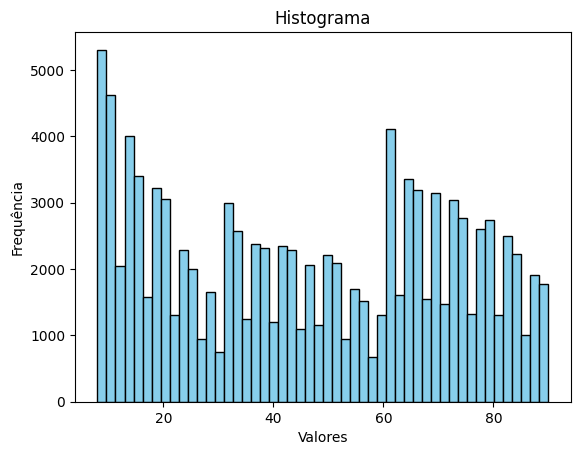

saldo_vencido


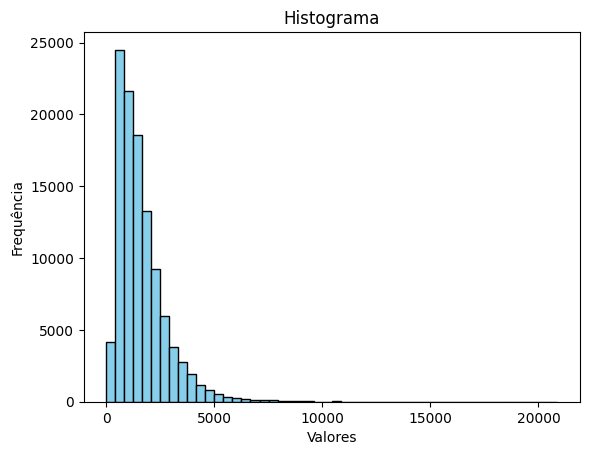

pagamento


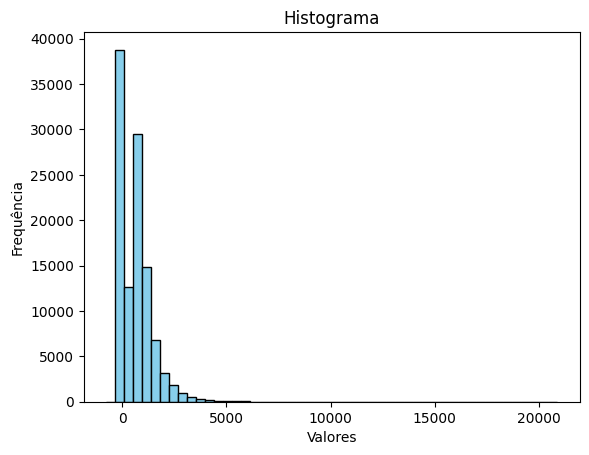

IDADE


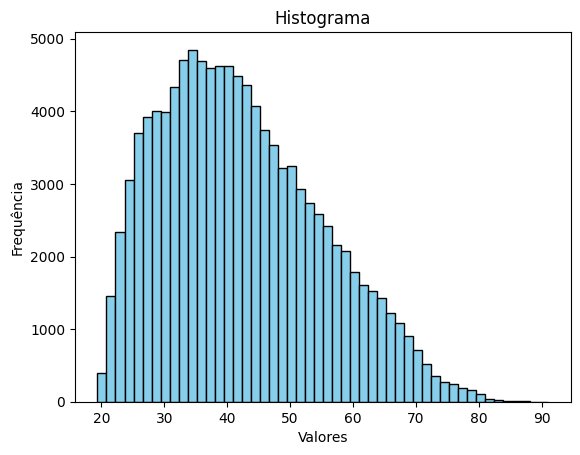

VAR_4


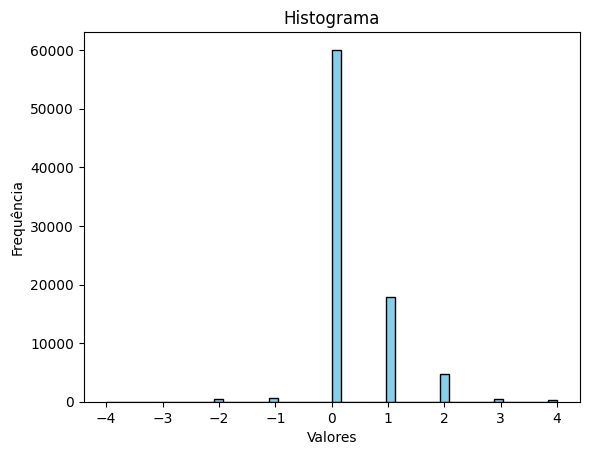

VAR_5


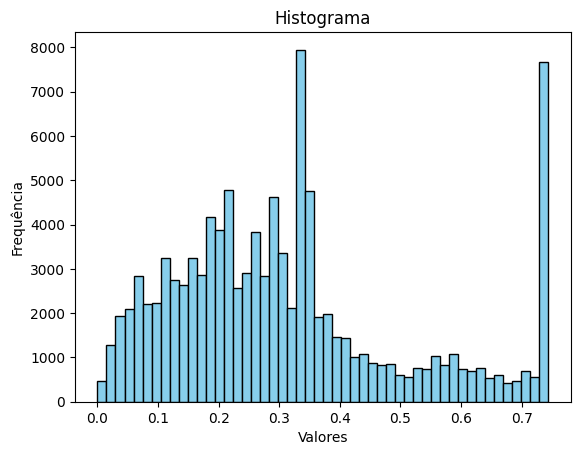

VAR_7


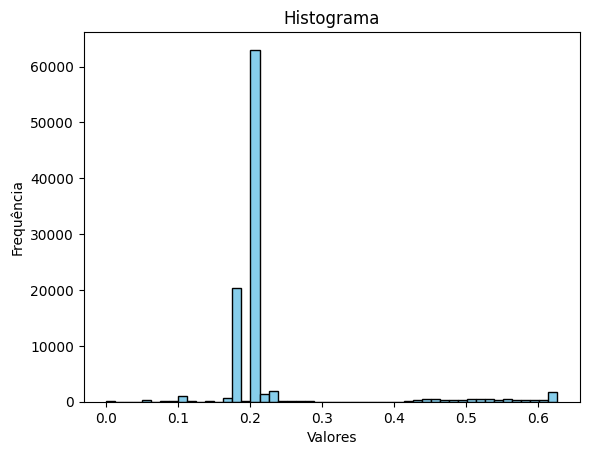

VAR_8


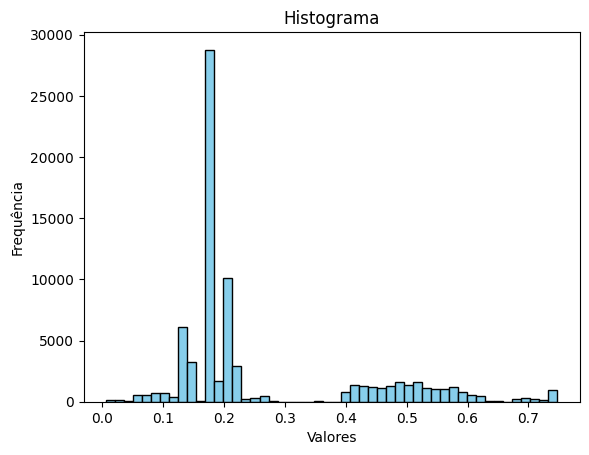

VAR_9


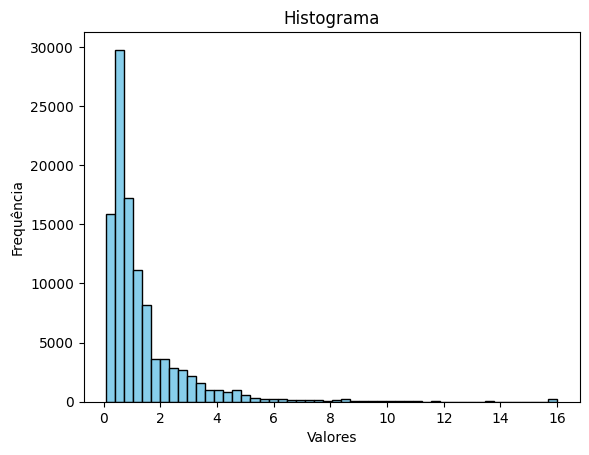

VAR_11


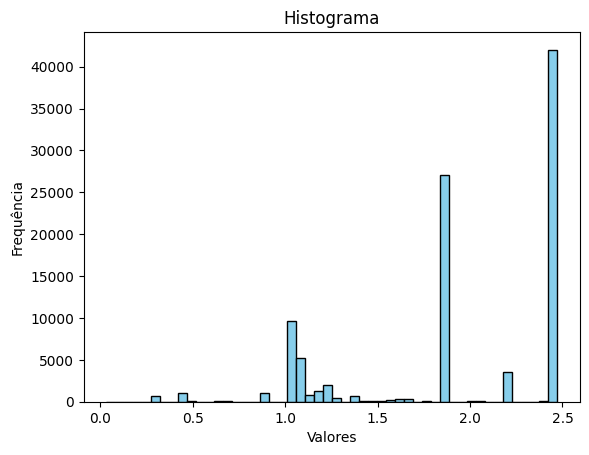

VAR_12


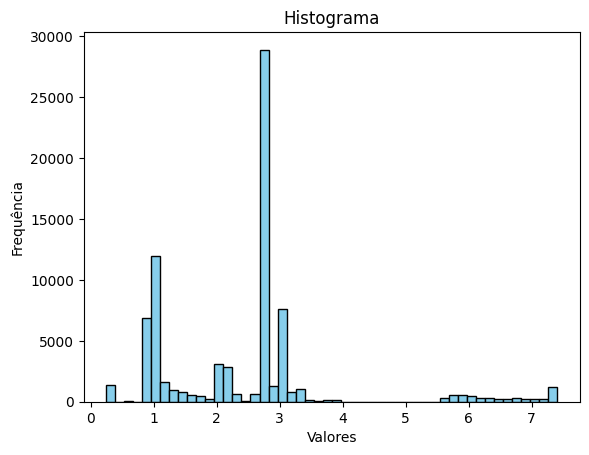

VAR_15


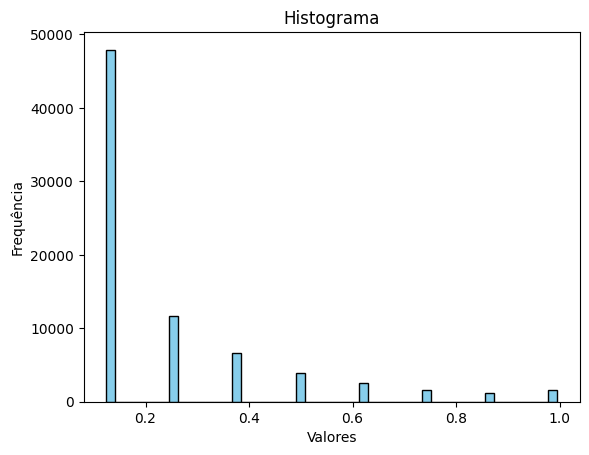

VAR_17


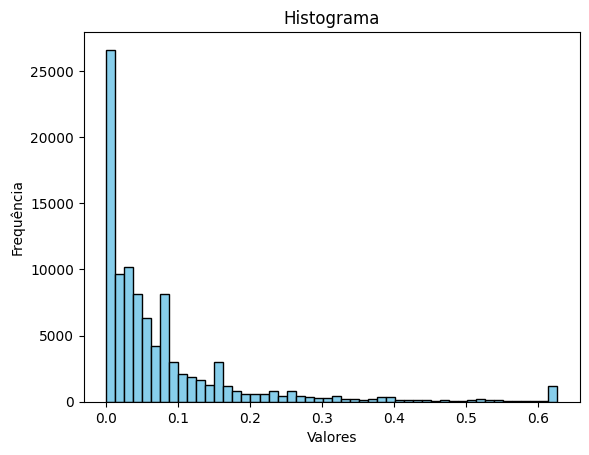

VAR_18


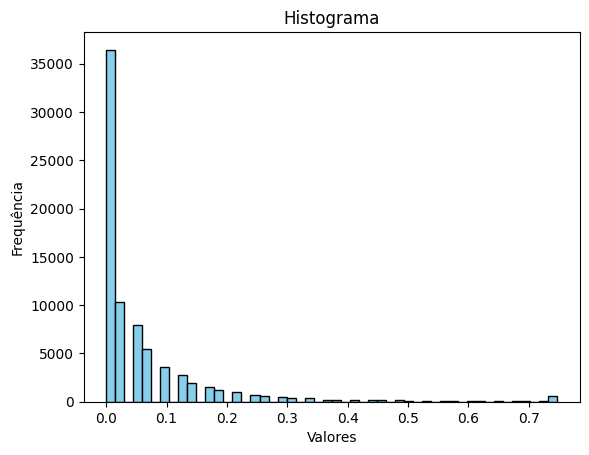

VAR_21


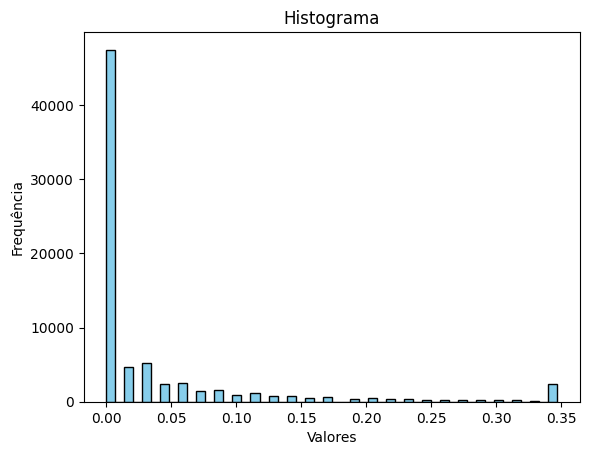

VAR_22


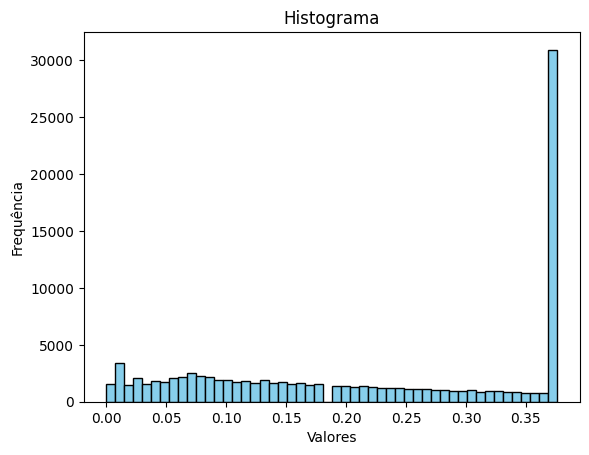

VAR_23


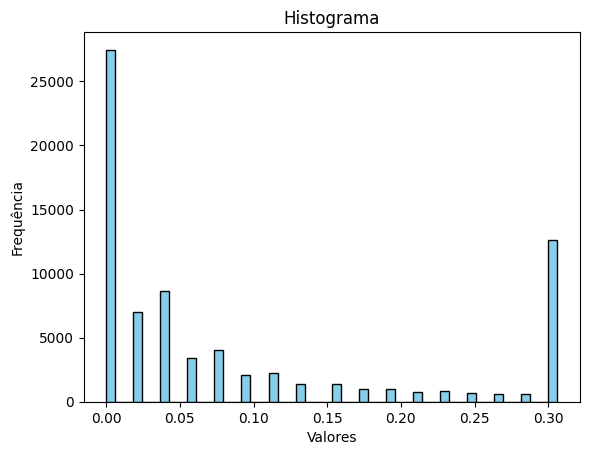

VAR_32


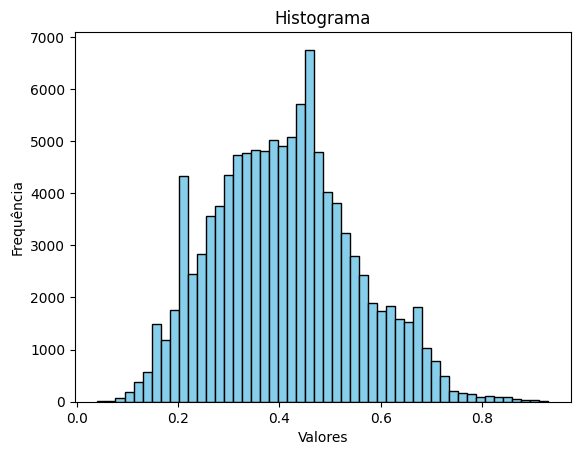

VAR_33


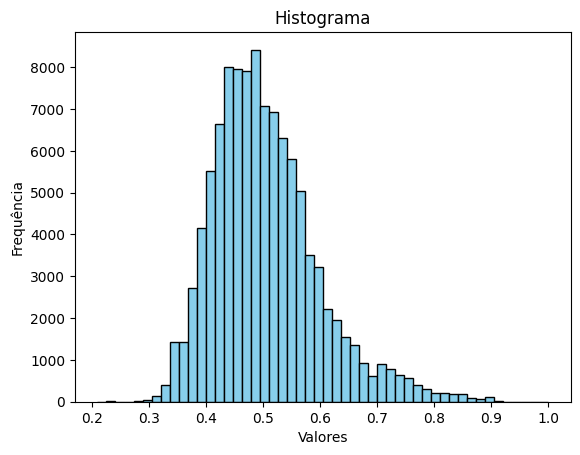

VAR_34


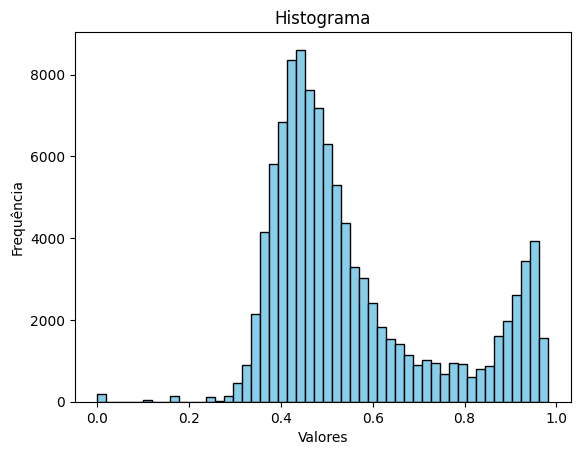

VAR_35


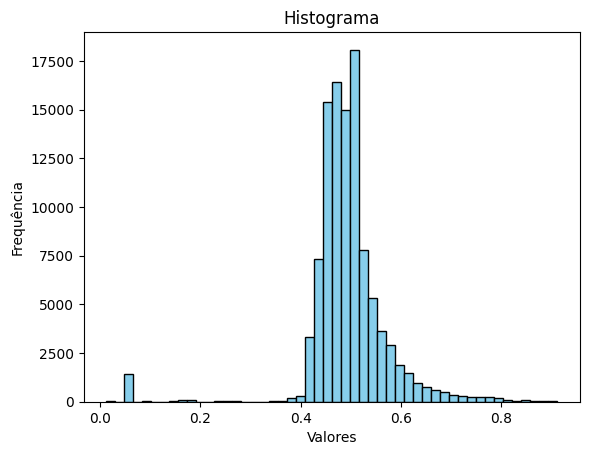

VAR_40


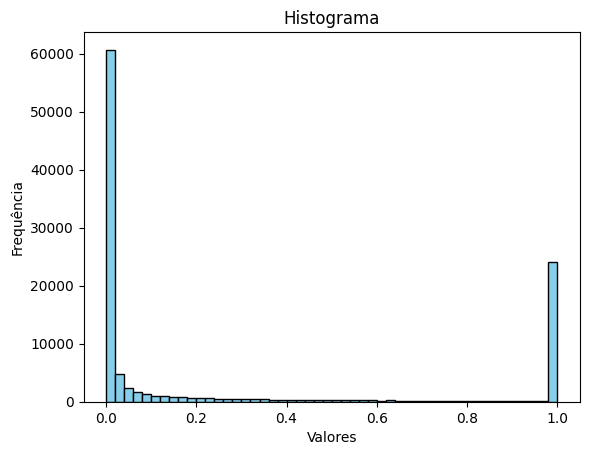

VAR_134


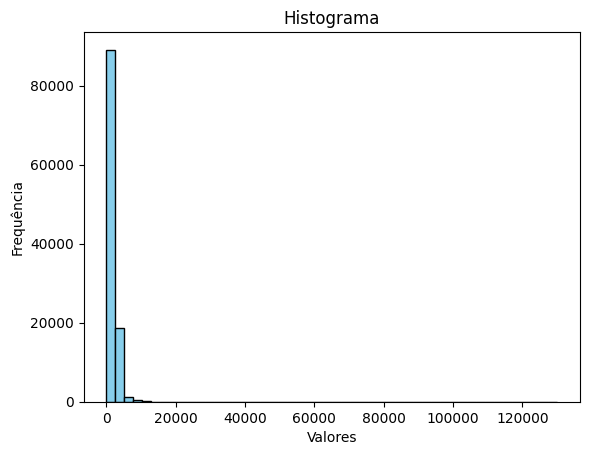

VAR_138


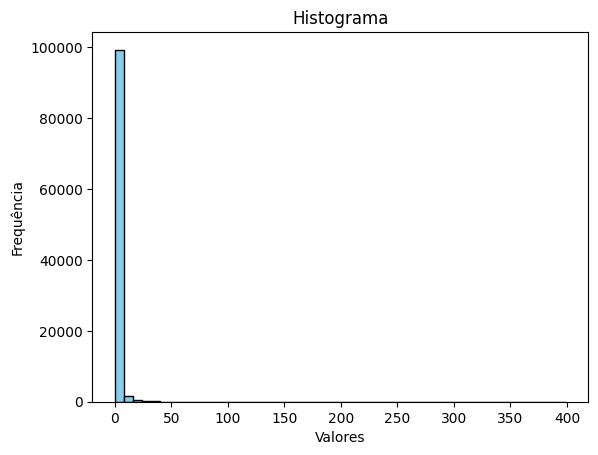

VAR_139


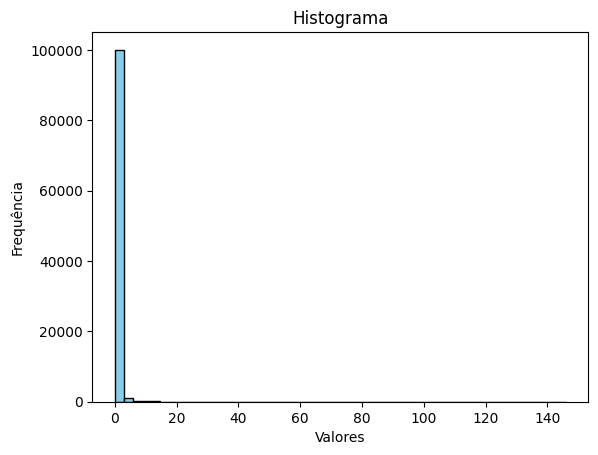

VAR_140


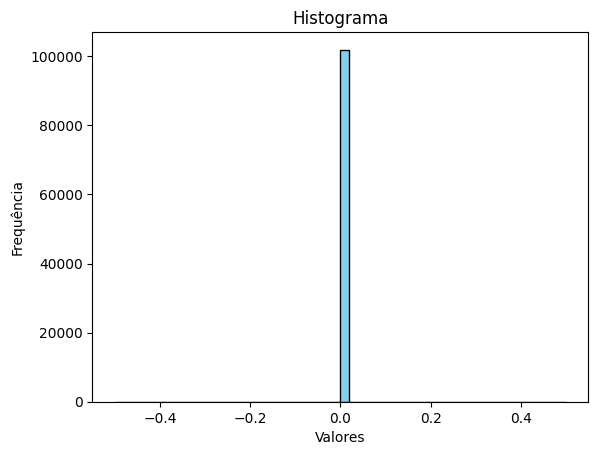

VAR_141


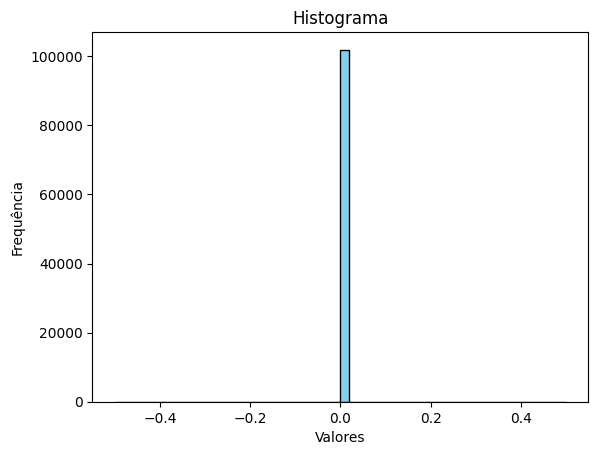

VAR_142


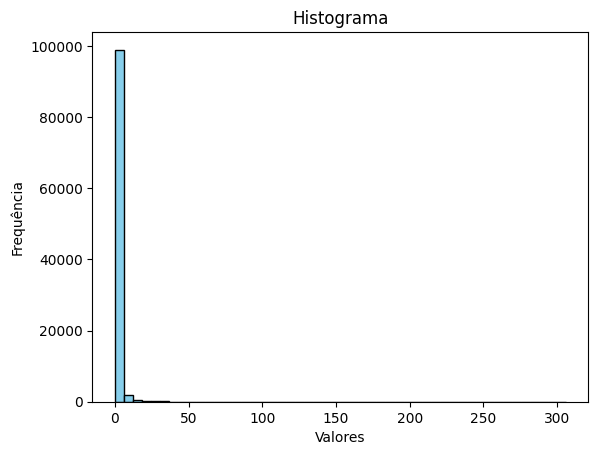

VAR_143


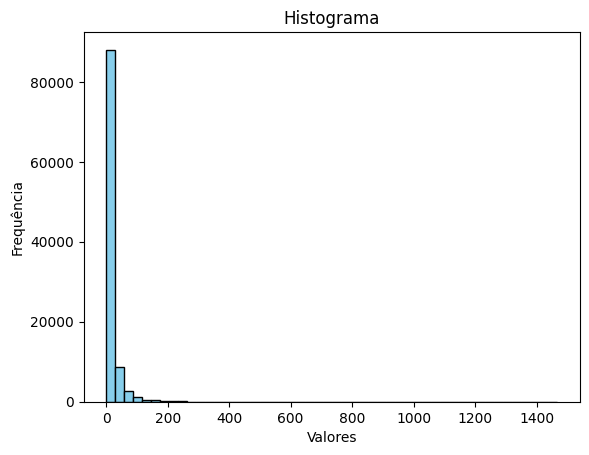

VAR_144


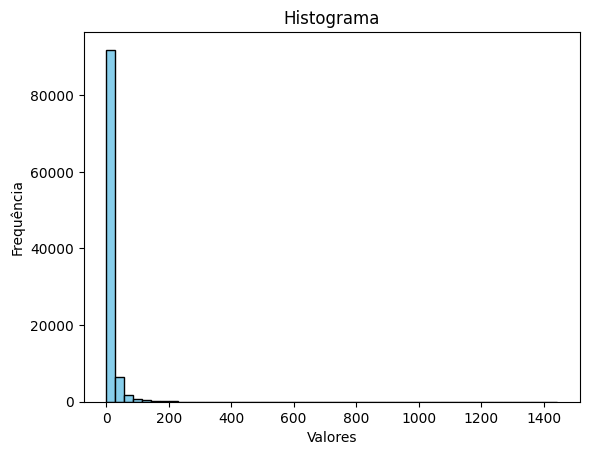

VAR_145


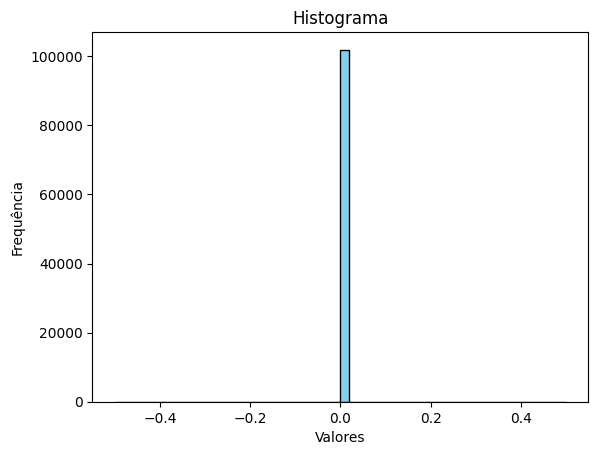

VAR_146


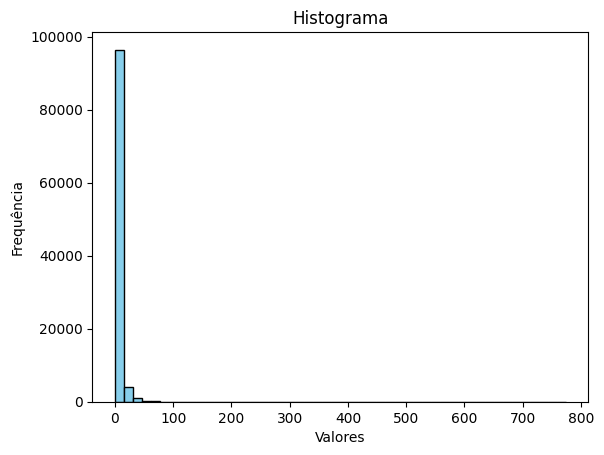

VAR_147


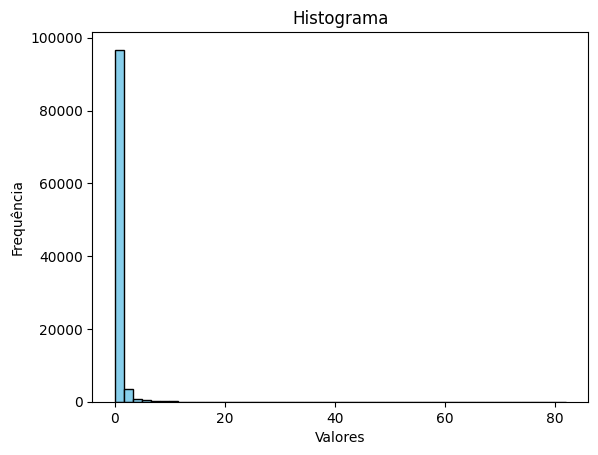

VAR_148


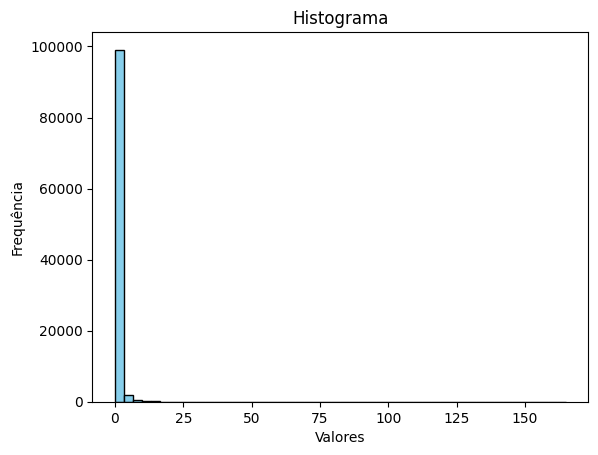

VAR_149


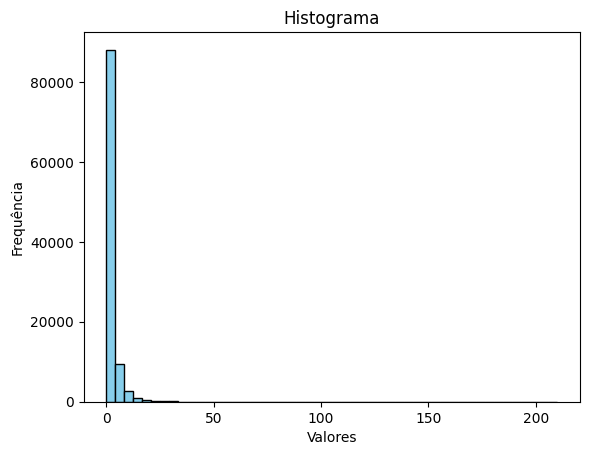

VAR_150


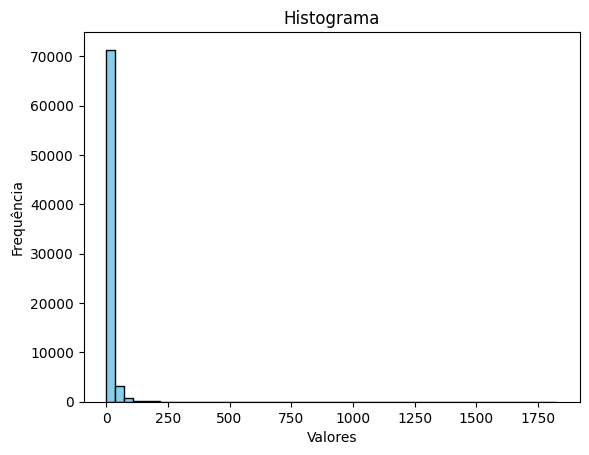

VAR_151


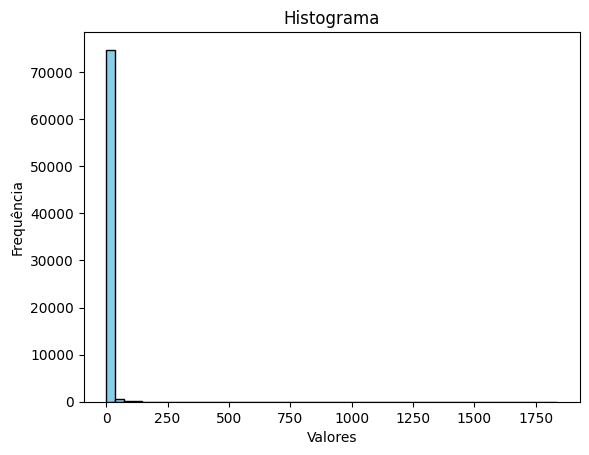

VAR_152


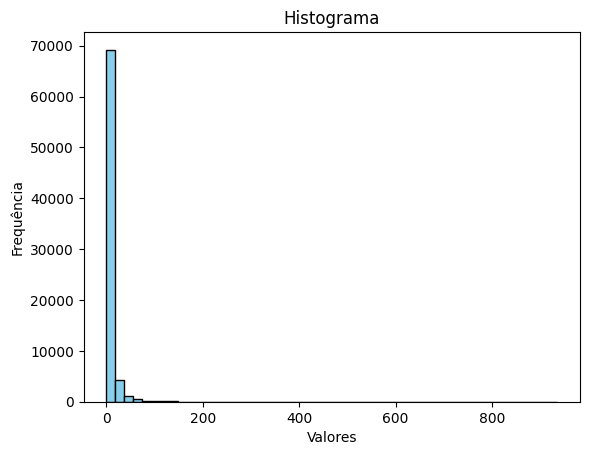

VAR_153


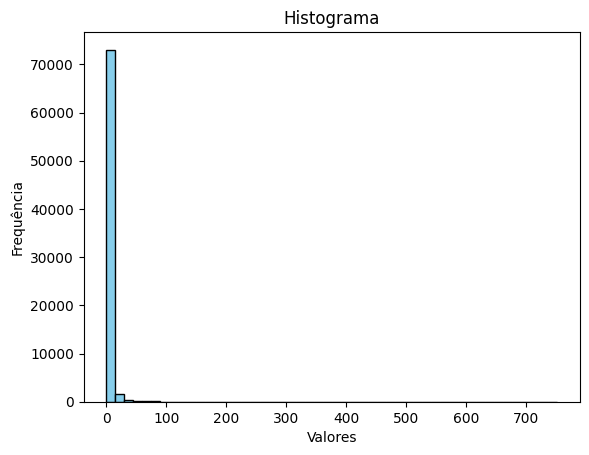

VAR_154


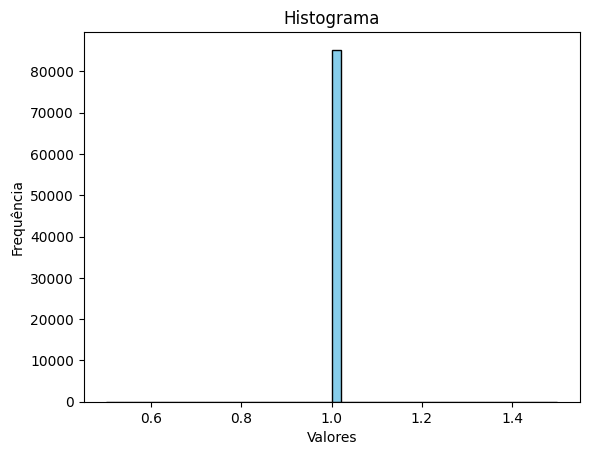

VAR_155


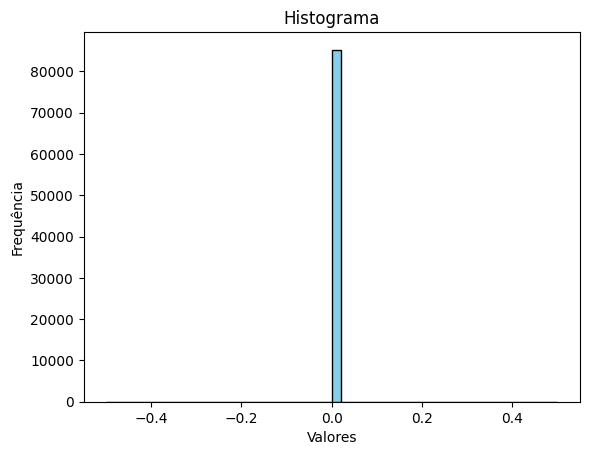

VAR_156


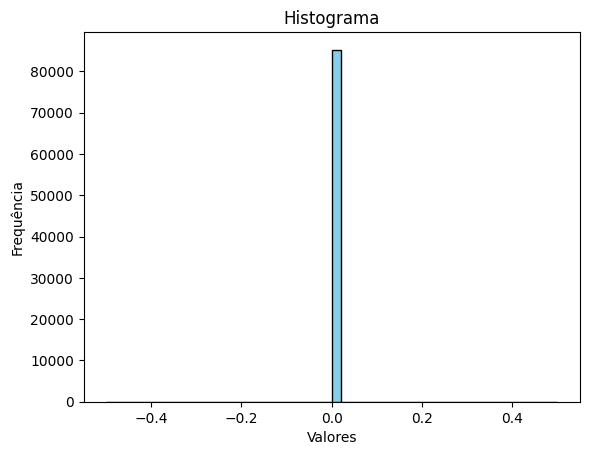

VAR_157


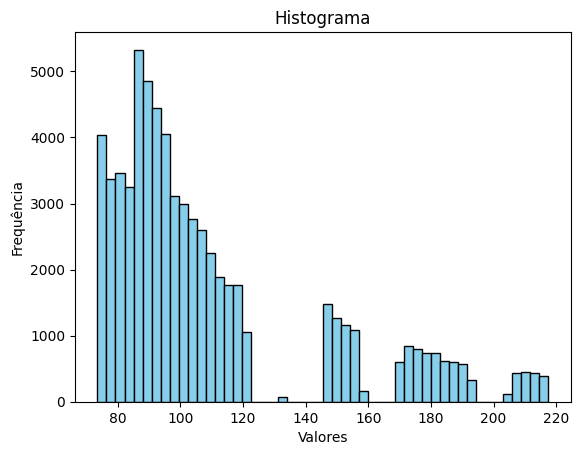

VAR_158


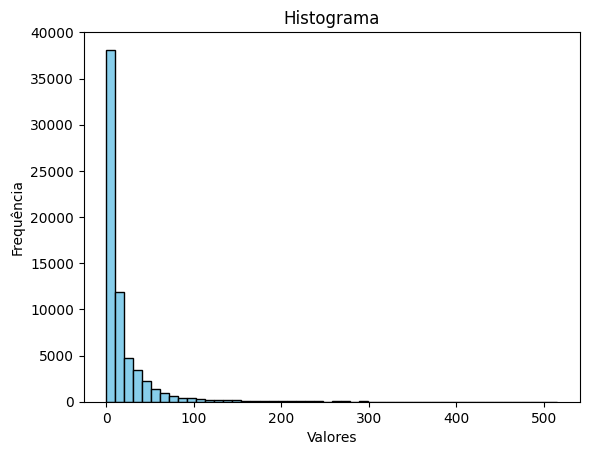

VAR_159


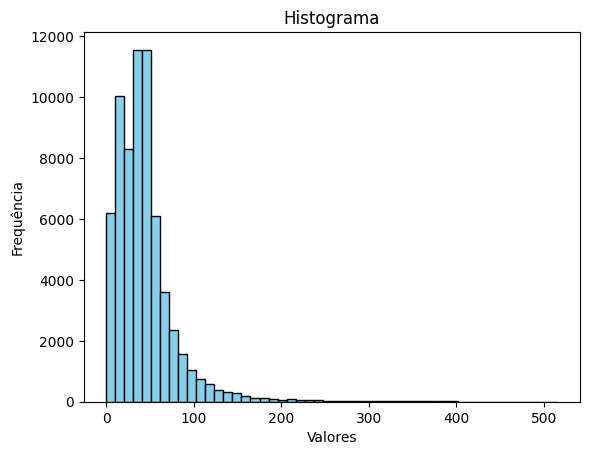

VAR_160


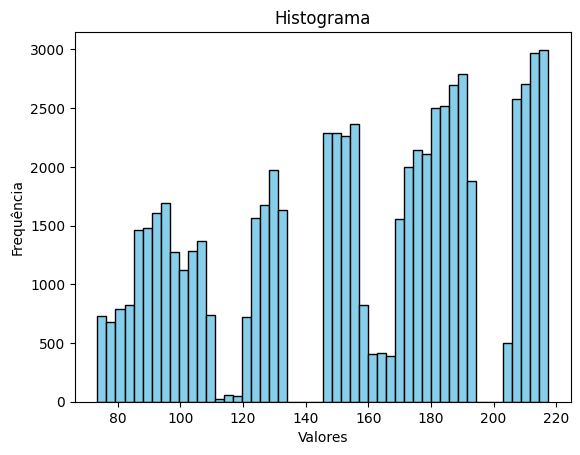

VAR_161


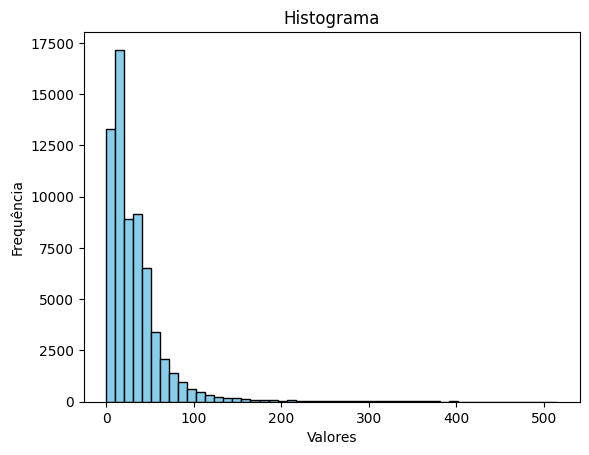

VAR_162


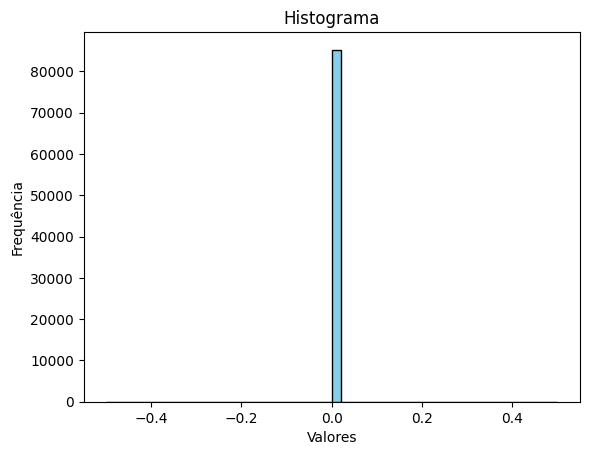

VAR_163


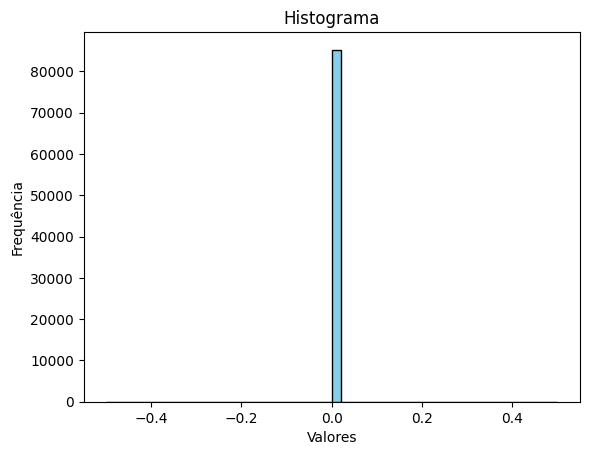

VAR_164


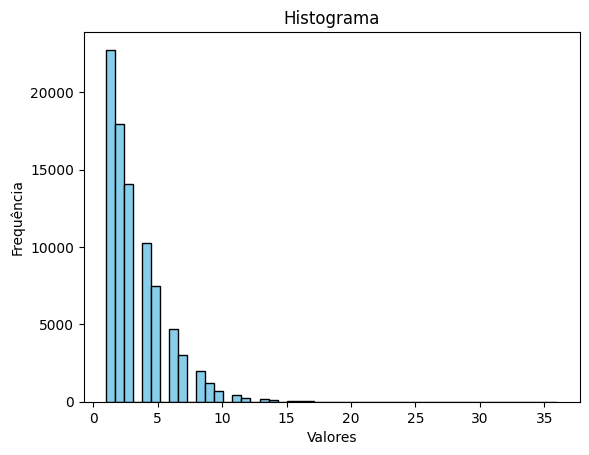

VAR_165


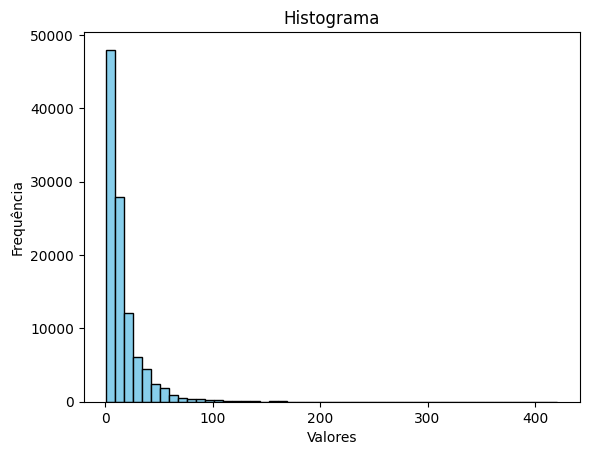

VAR_166


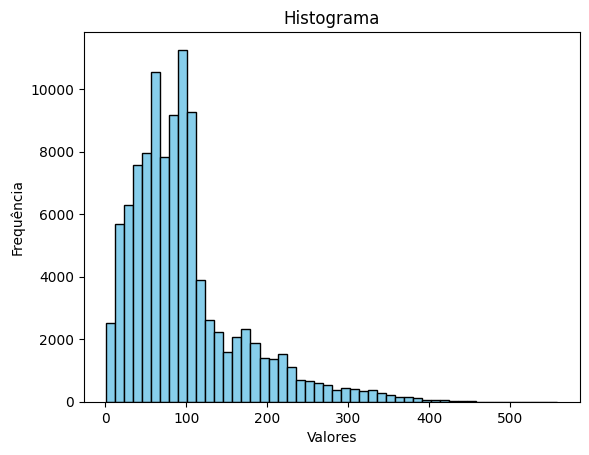

VAR_167


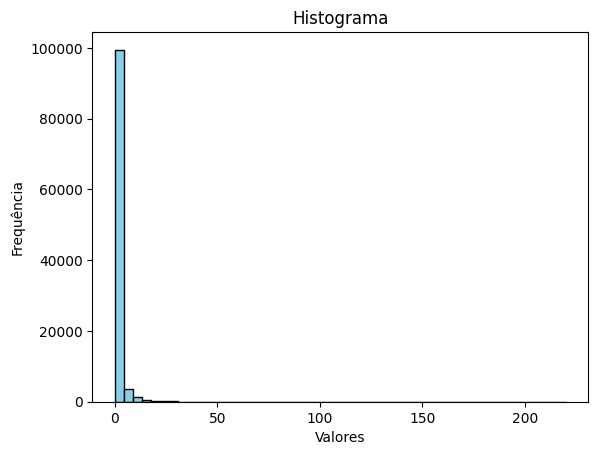

VAR_168


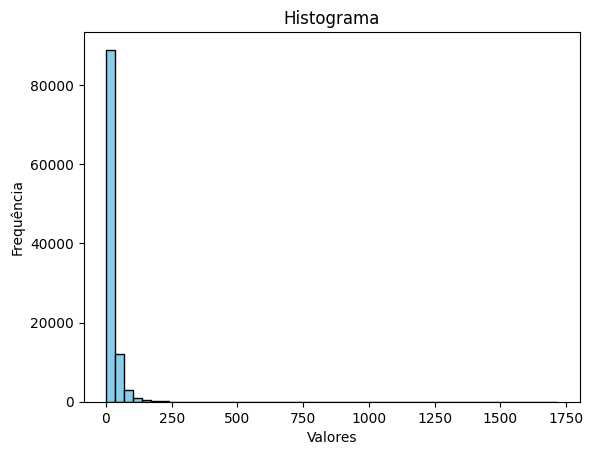

VAR_169


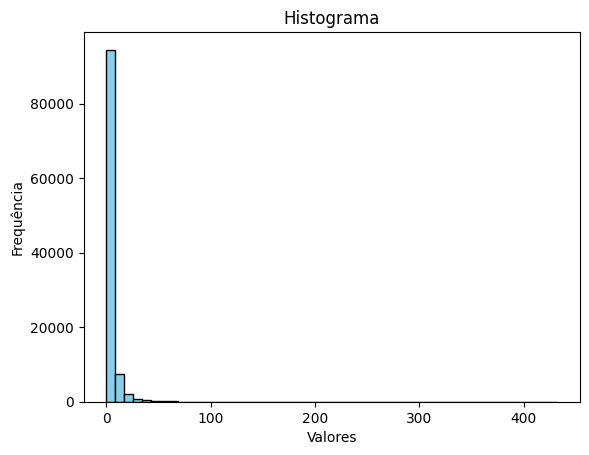

VAR_170


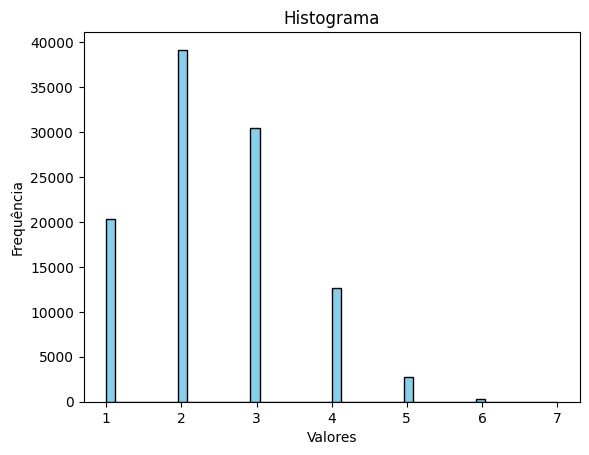

VAR_171


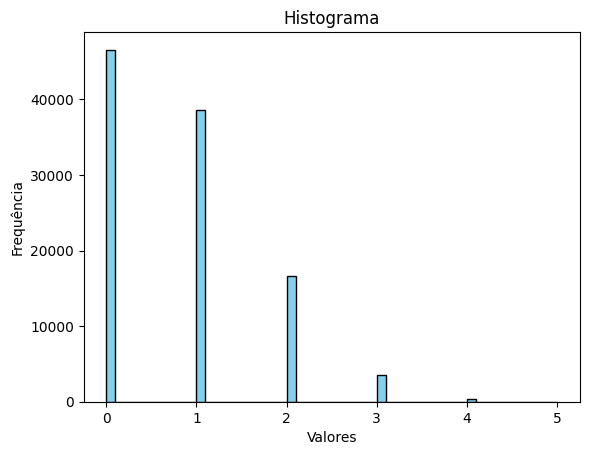

VAR_172


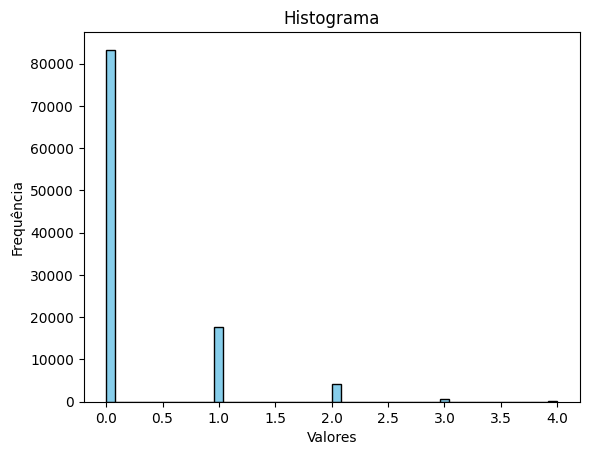

VAR_173


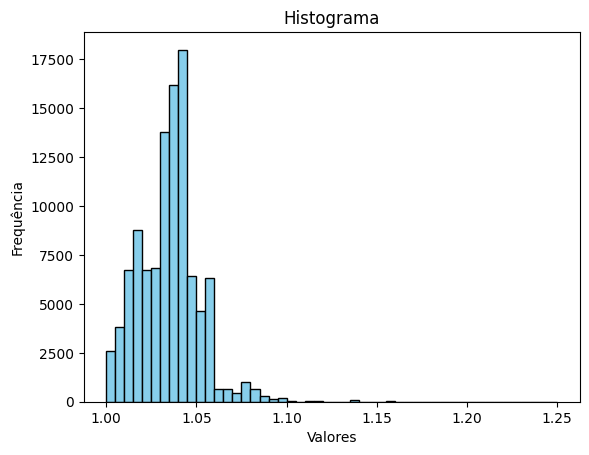

VAR_174


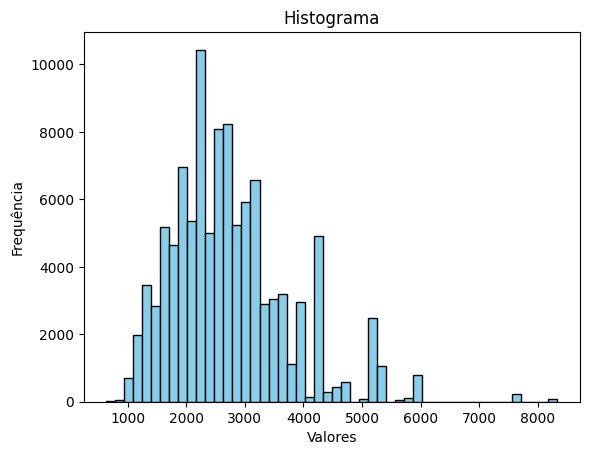

VAR_175


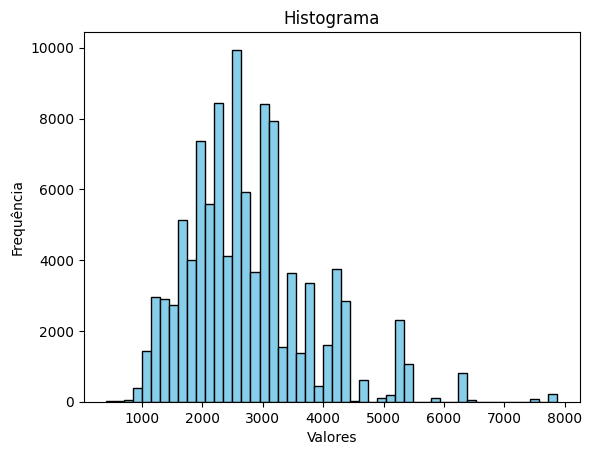

VAR_176


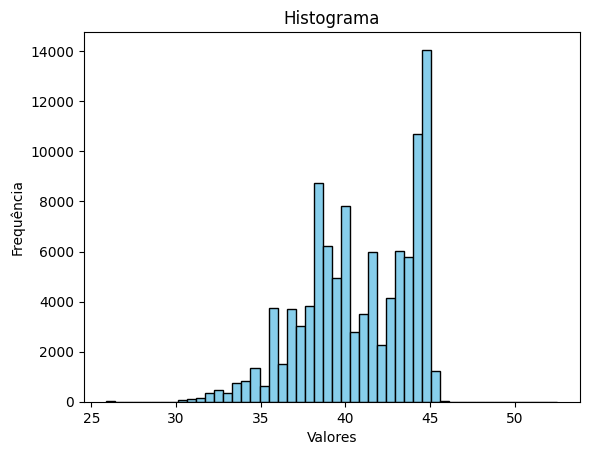

VAR_177


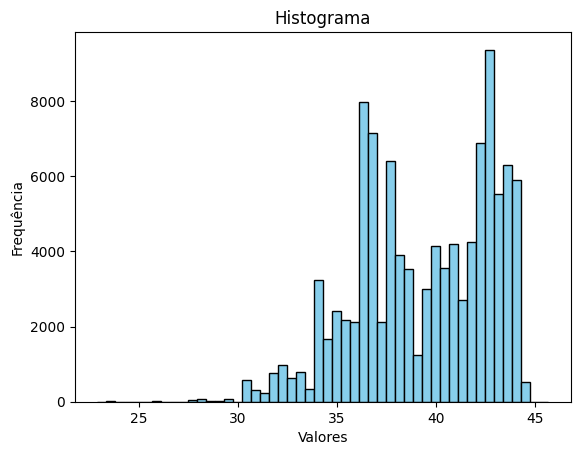

VAR_178


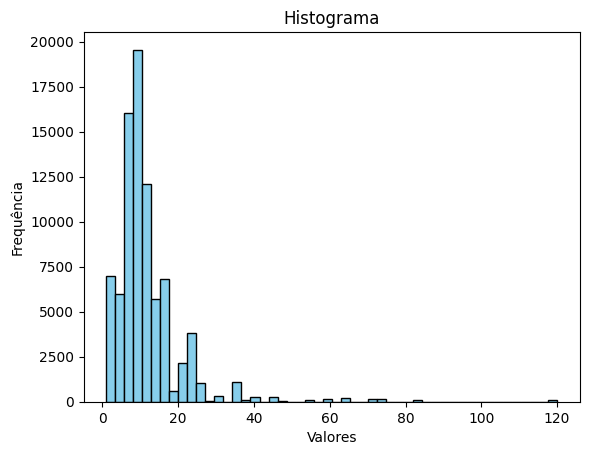

VAR_179


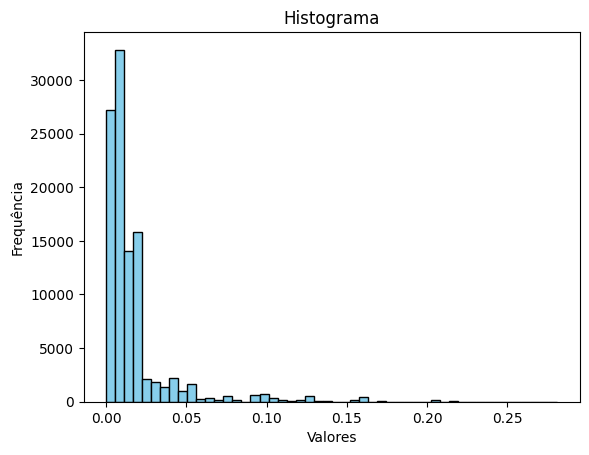

VAR_180


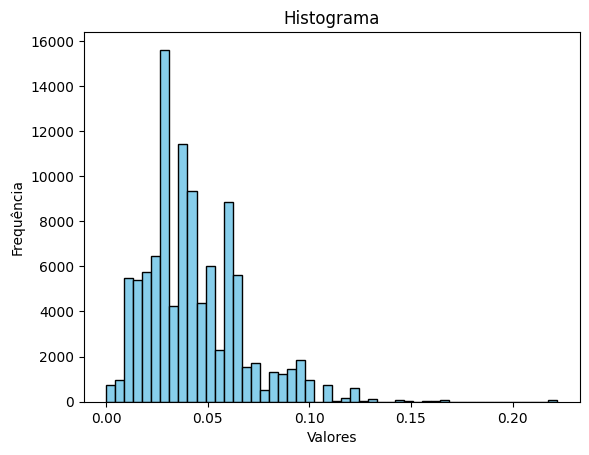

VAR_181


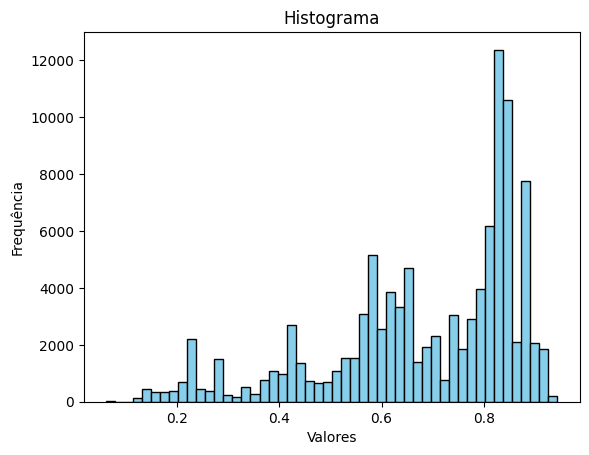

VAR_182


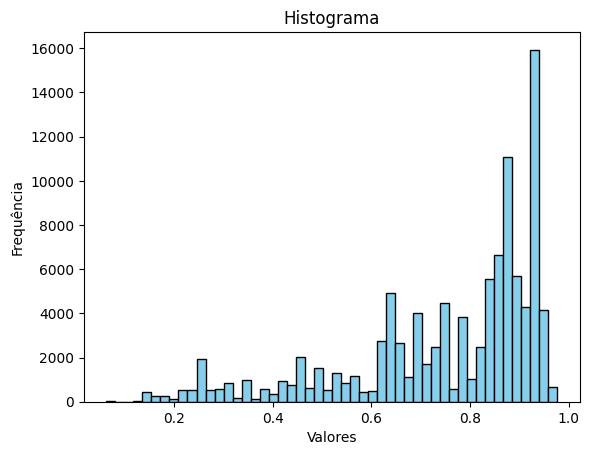

VAR_183


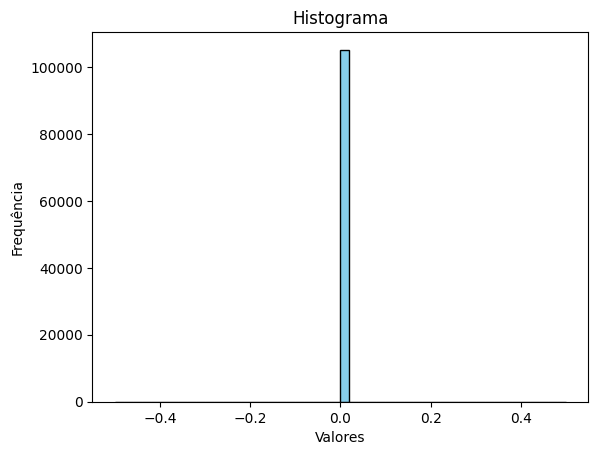

VAR_184


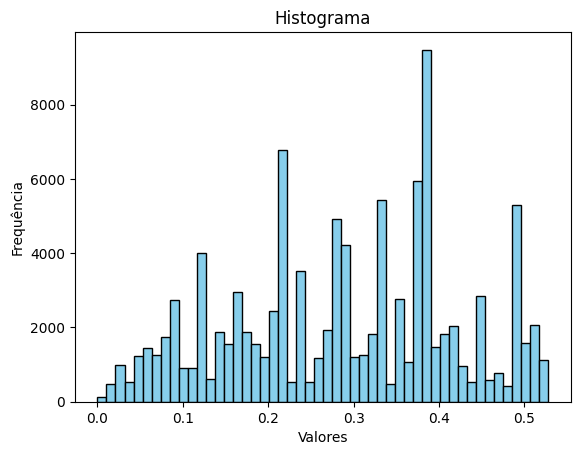

VAR_185


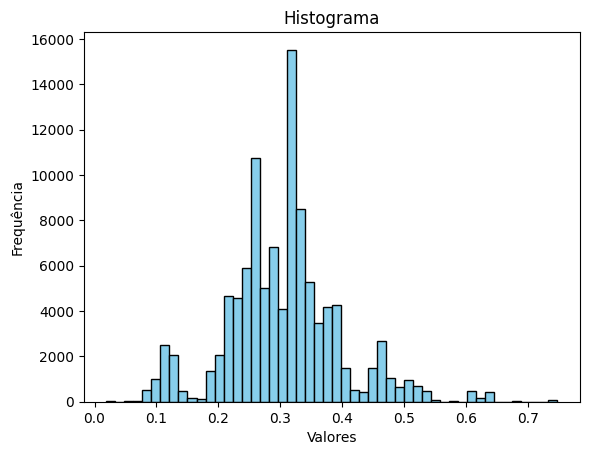

VAR_186


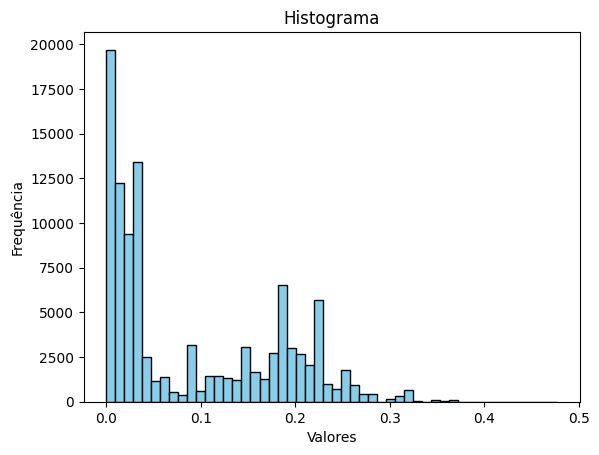

VAR_187


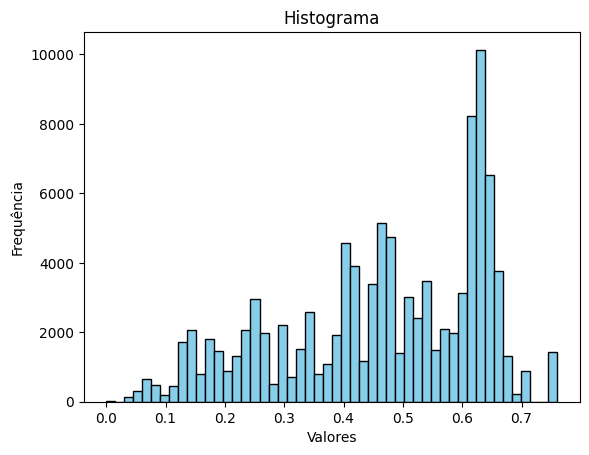

VAR_188


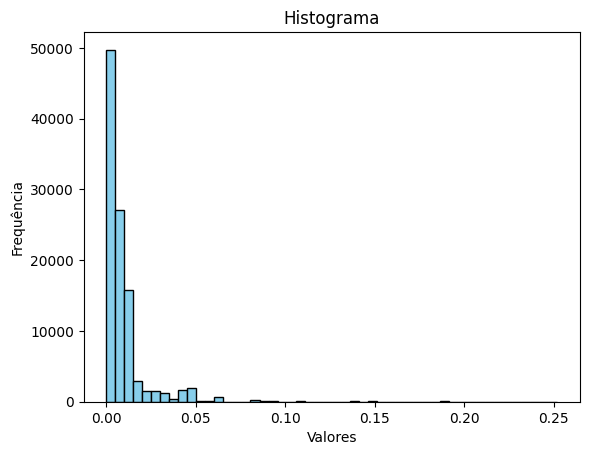

VAR_189


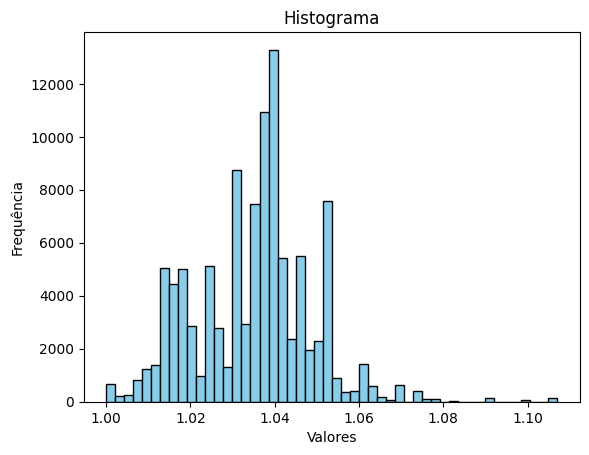

VAR_190


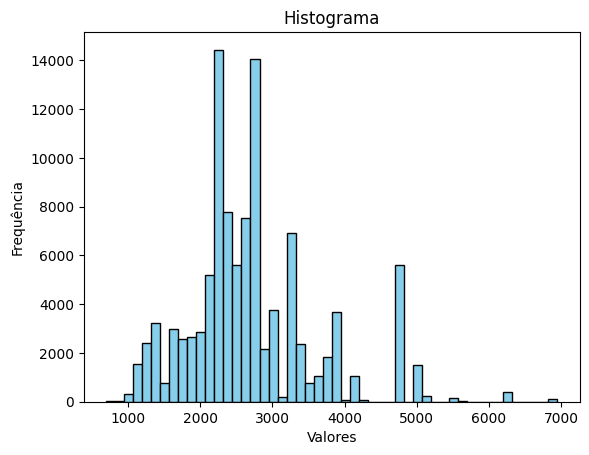

VAR_191


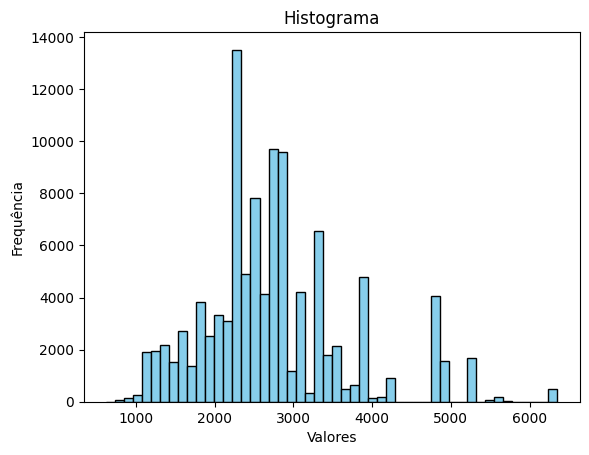

VAR_192


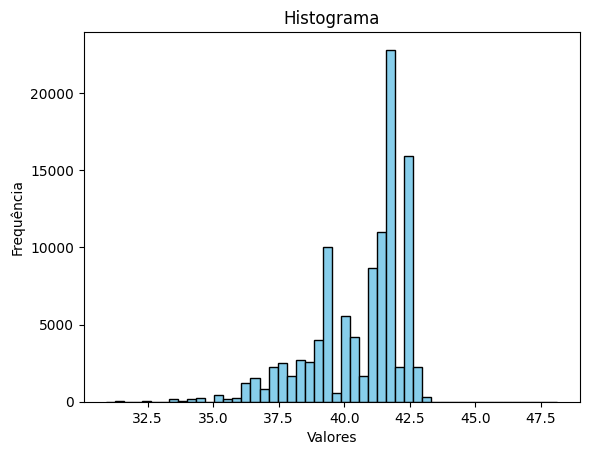

VAR_193


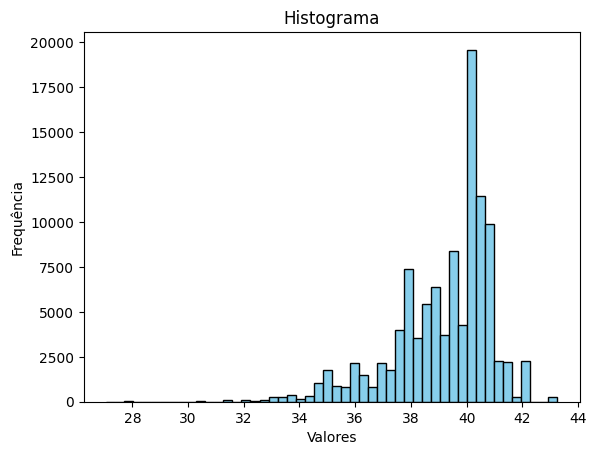

VAR_194


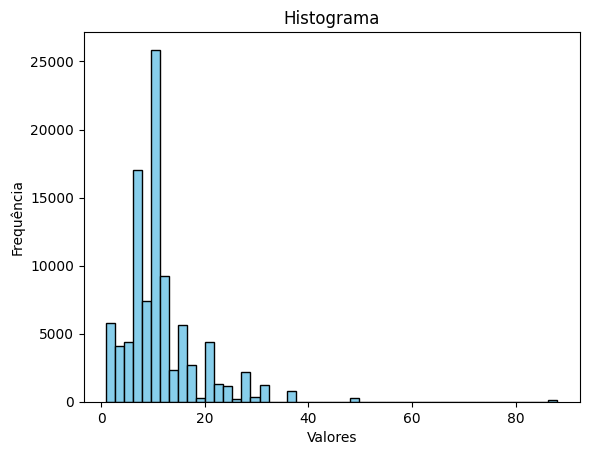

VAR_195


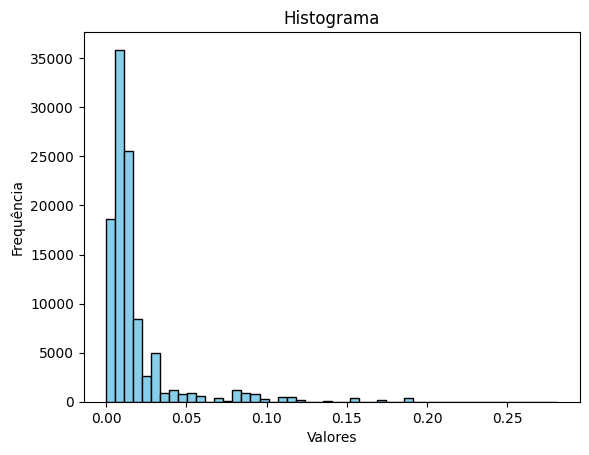

VAR_196


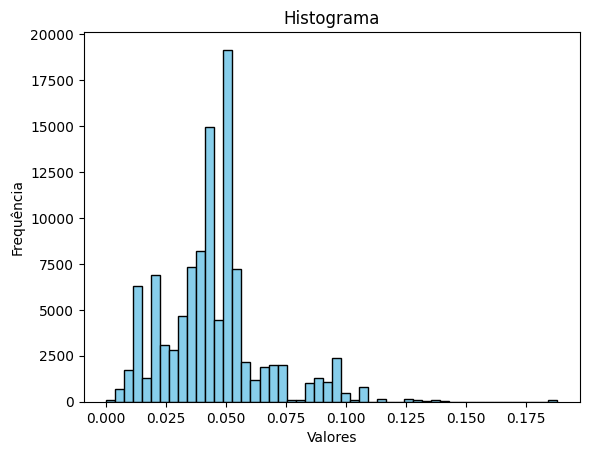

VAR_197


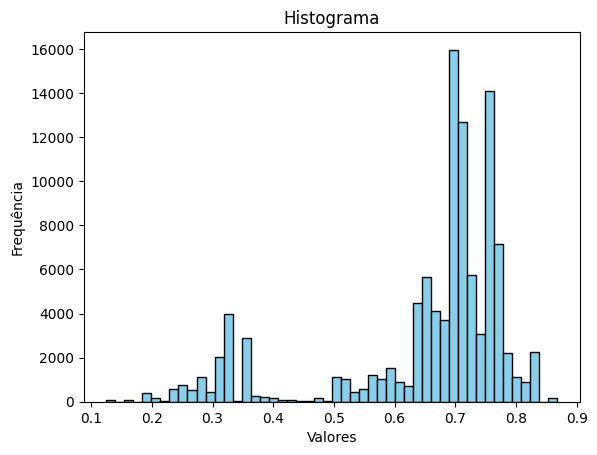

VAR_198


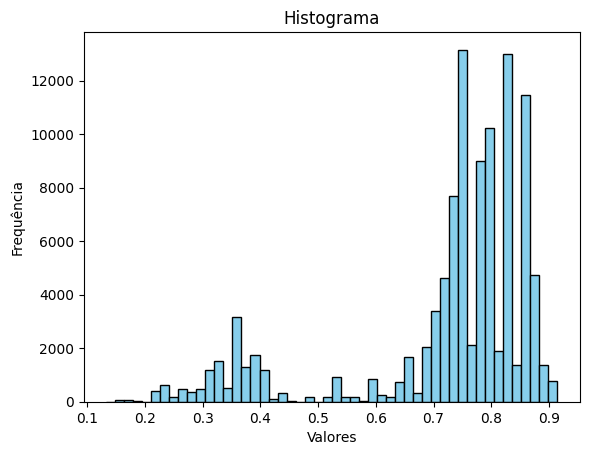

VAR_199


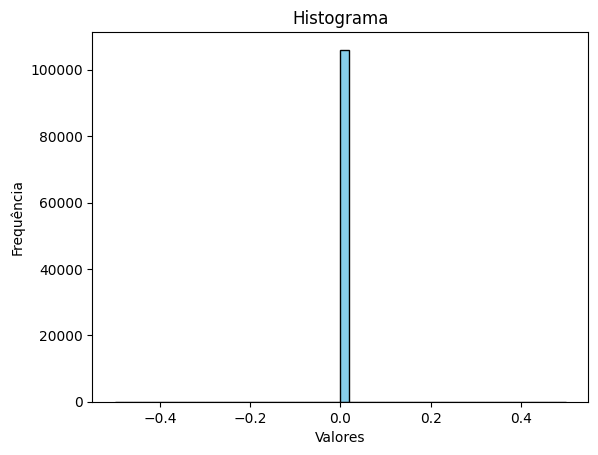

VAR_200


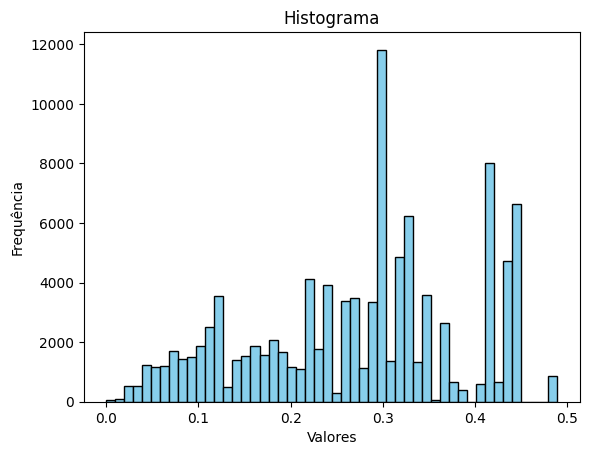

VAR_201


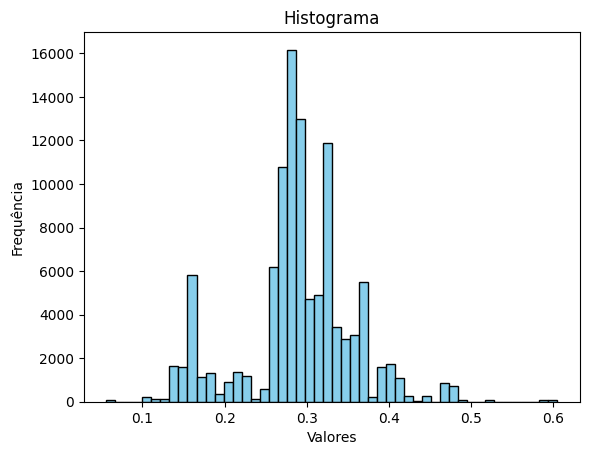

VAR_202


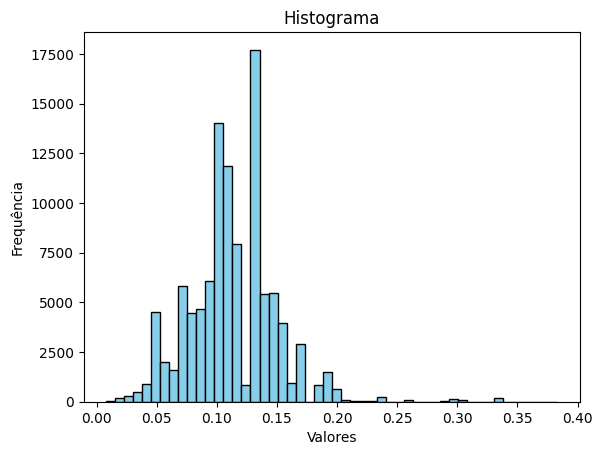

VAR_203


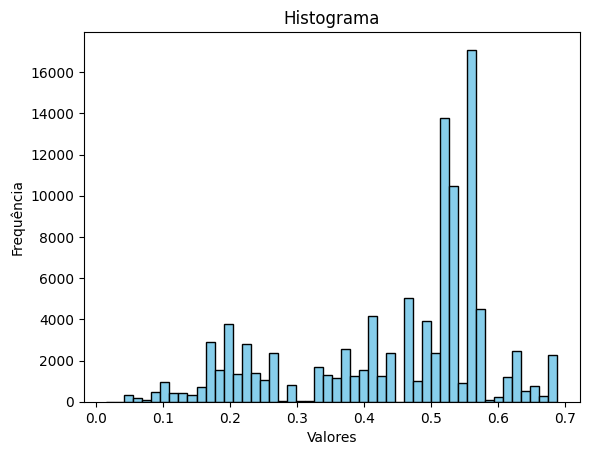

VAR_204


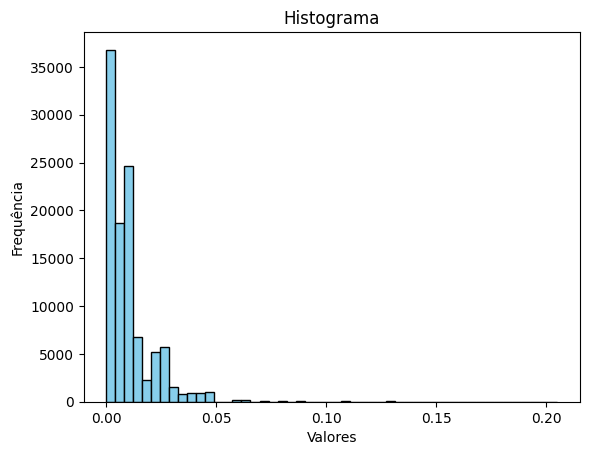

VAR_205


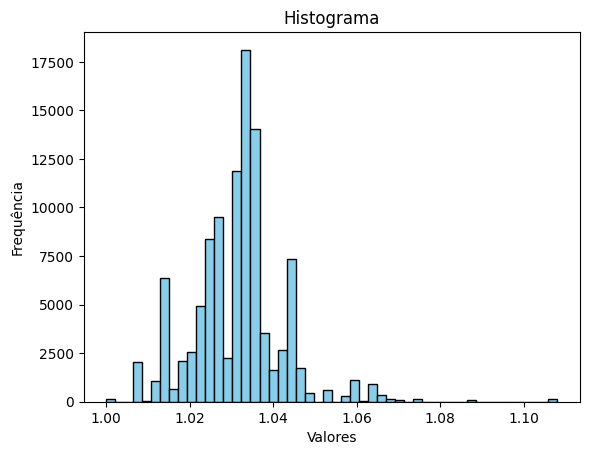

VAR_206


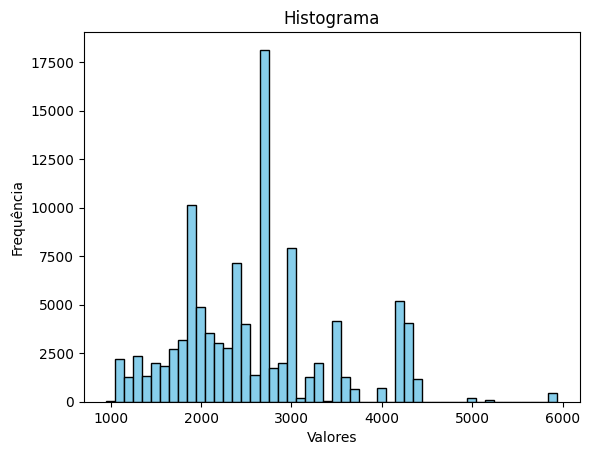

VAR_207


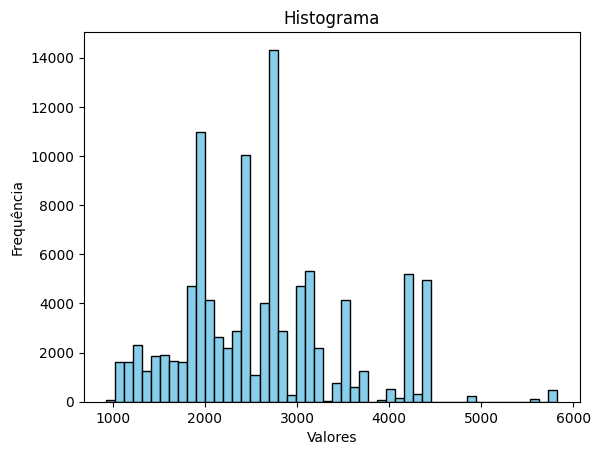

VAR_208


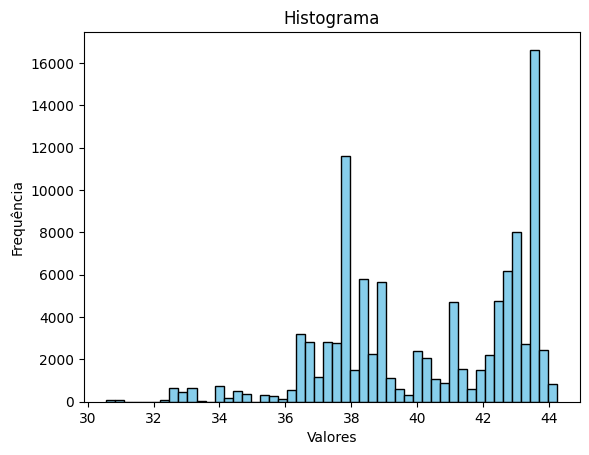

VAR_209


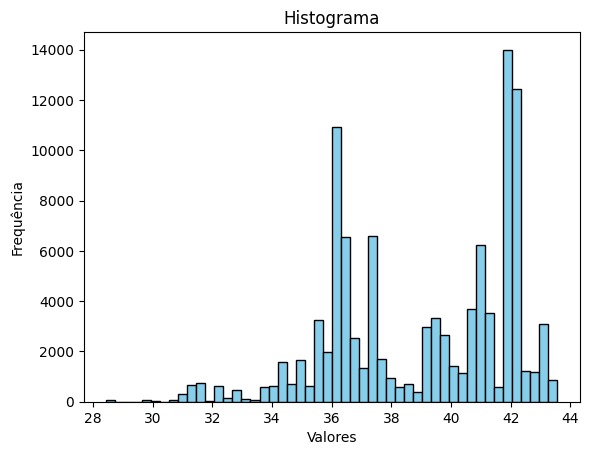

VAR_210


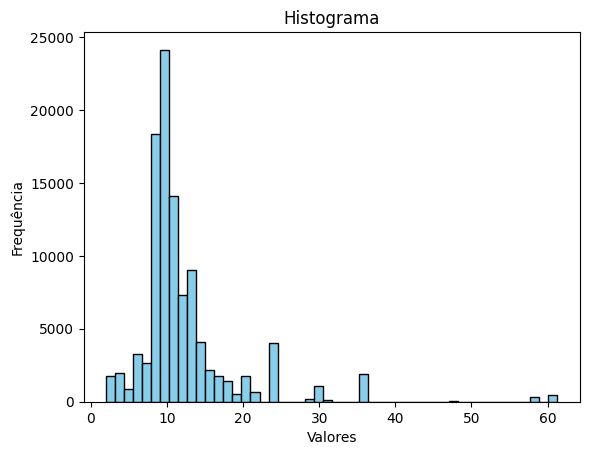

VAR_211


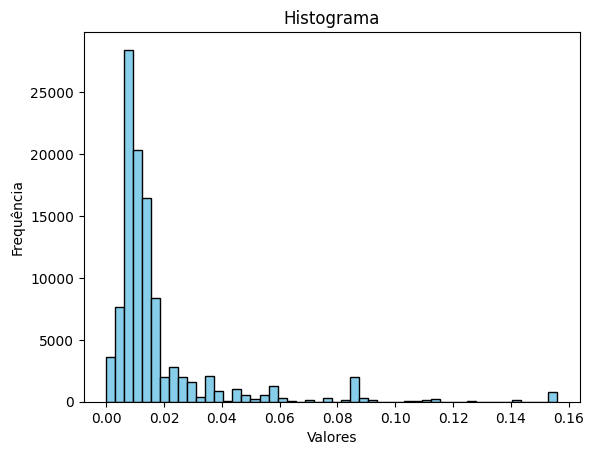

VAR_212


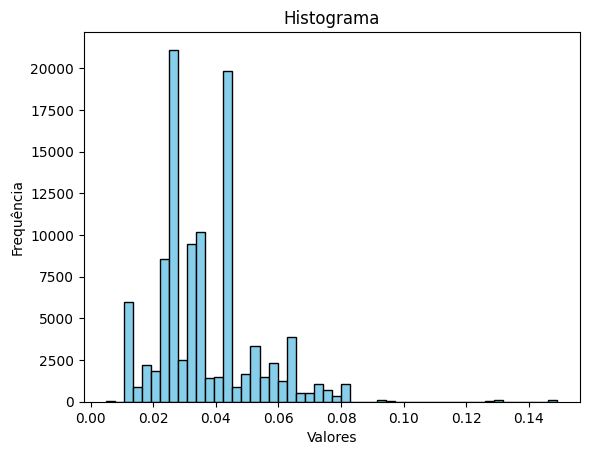

VAR_213


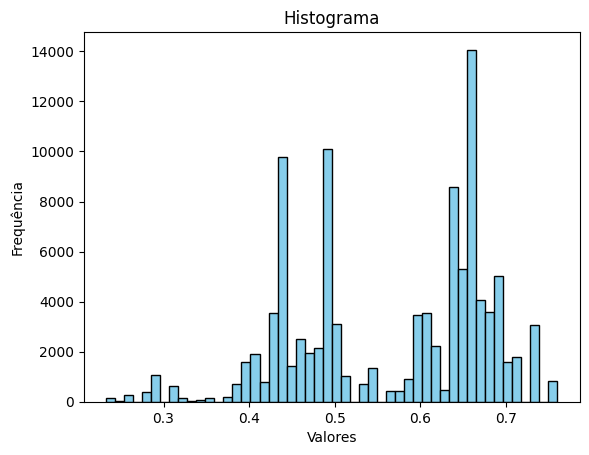

VAR_214


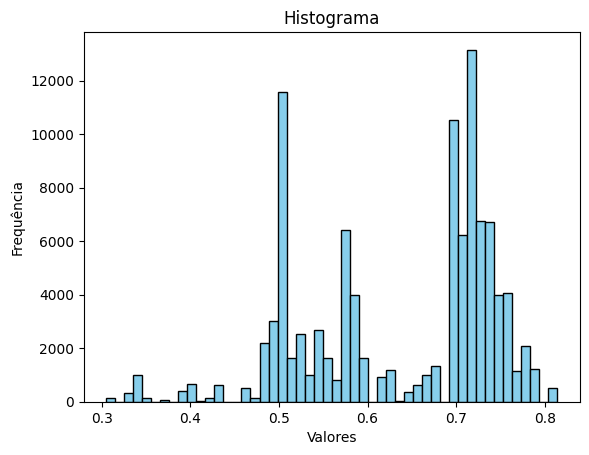

VAR_215


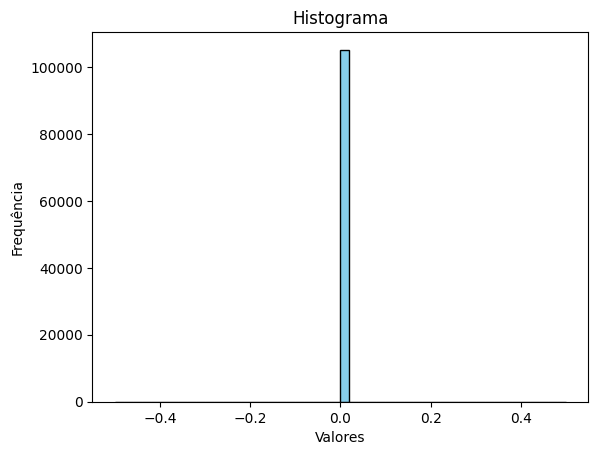

VAR_216


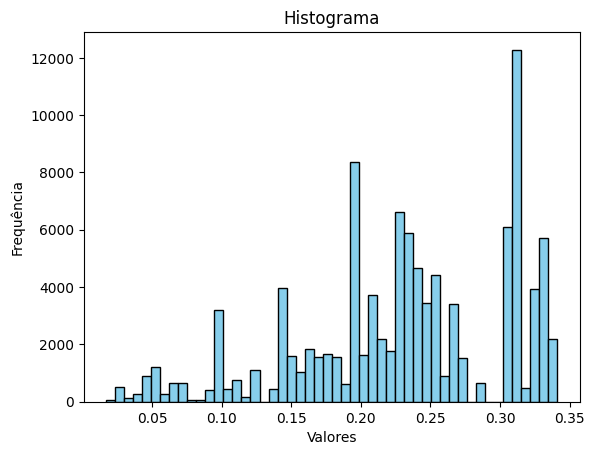

VAR_217


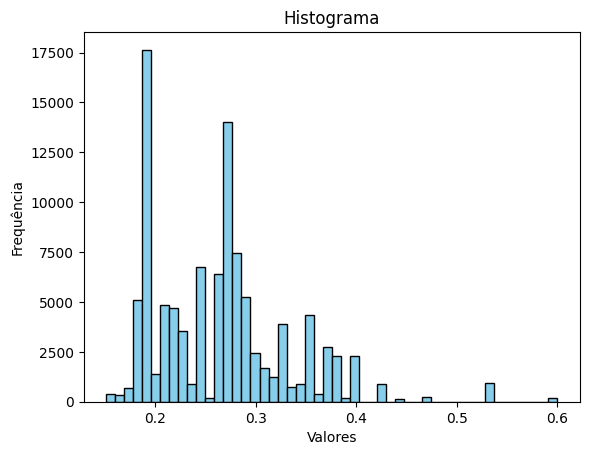

VAR_218


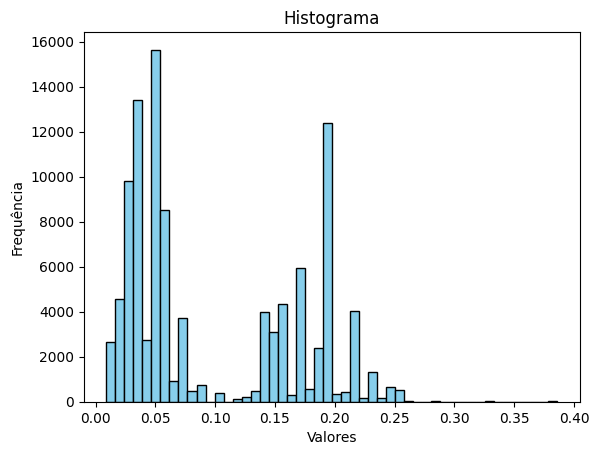

VAR_219


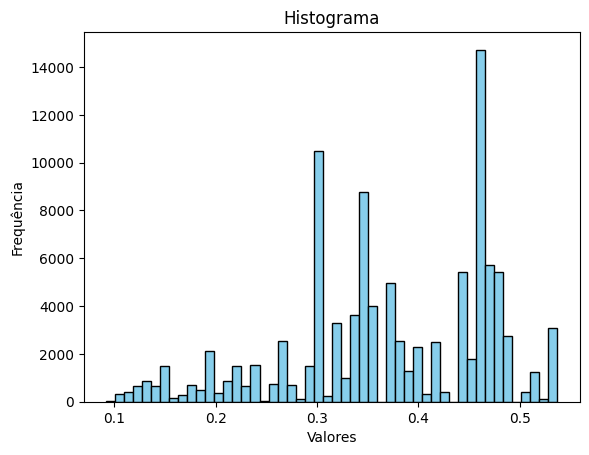

VAR_220


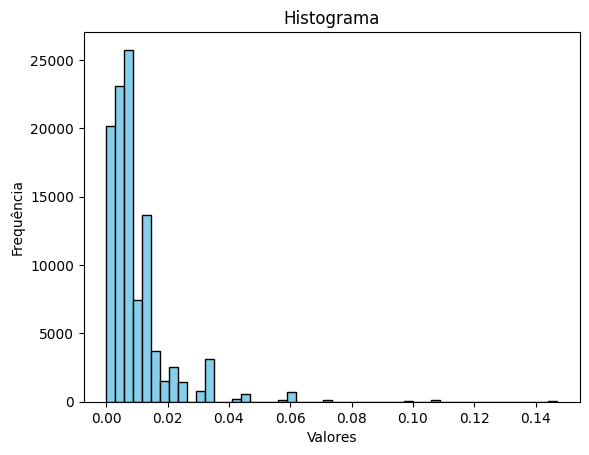

VAR_221


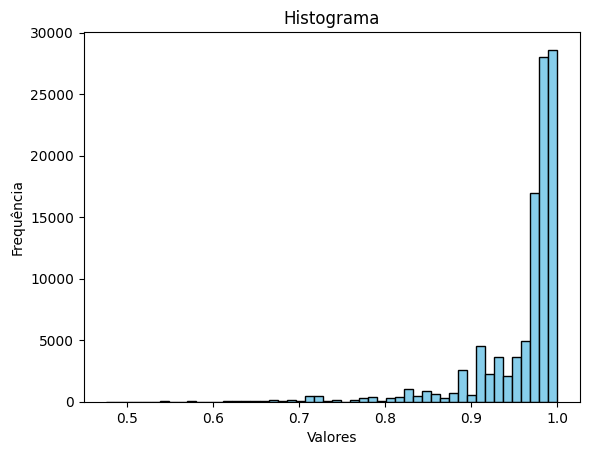

VAR_222


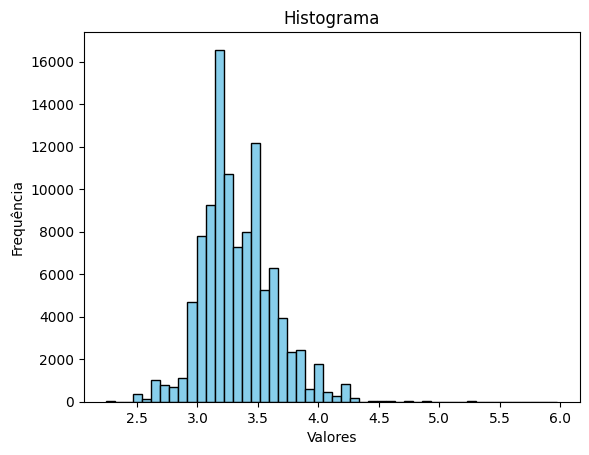

VAR_223


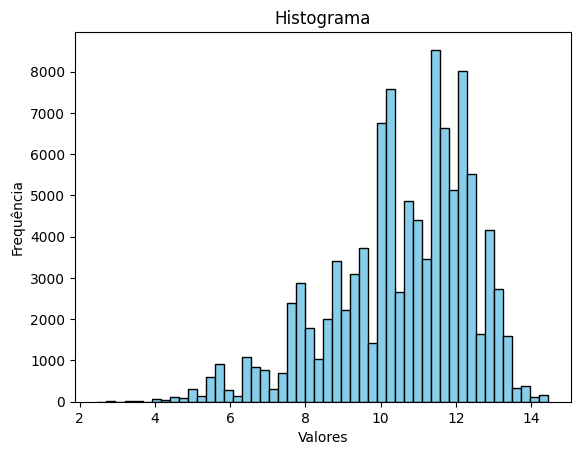

VAR_224


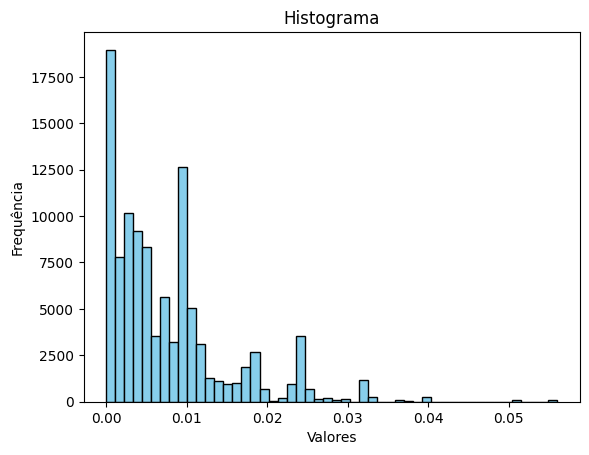

VAR_225


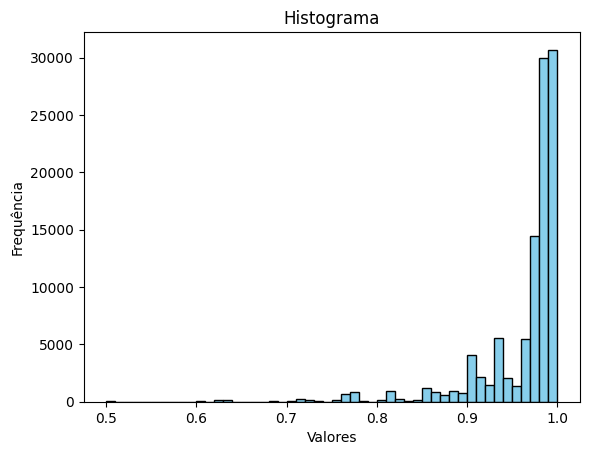

VAR_226


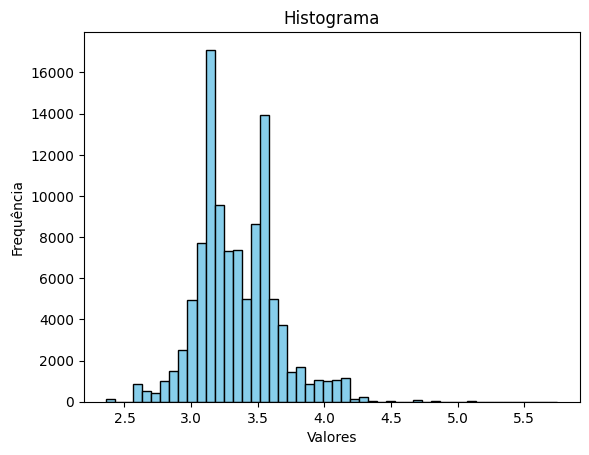

VAR_227


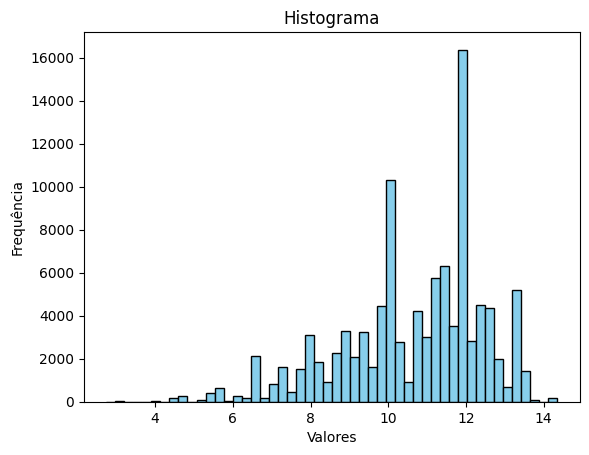

VAR_228


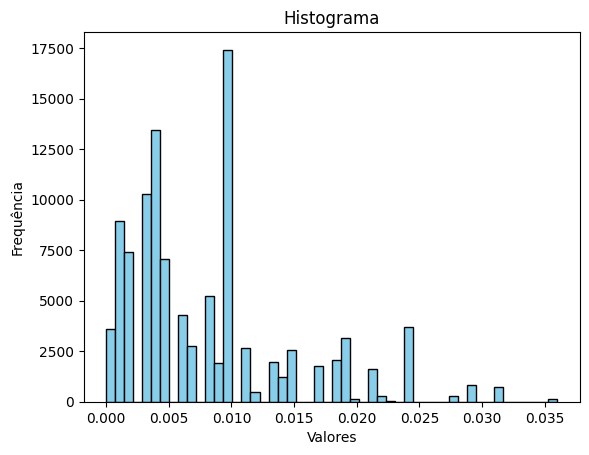

VAR_229


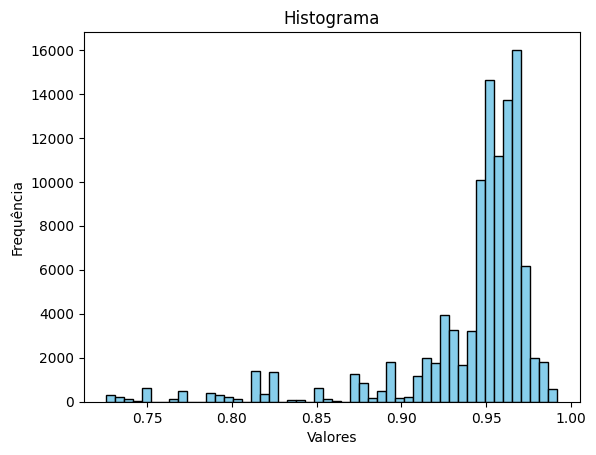

VAR_230


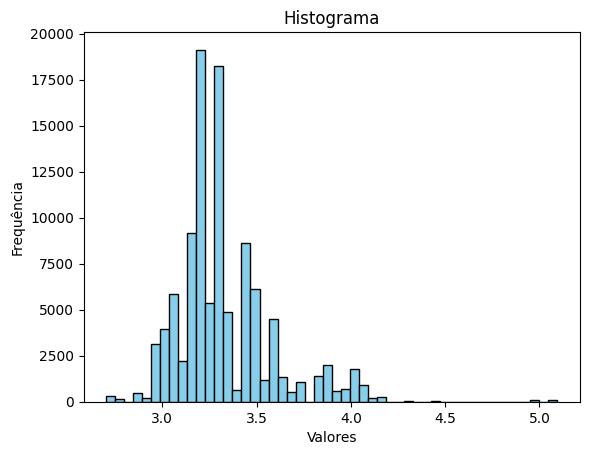

VAR_231


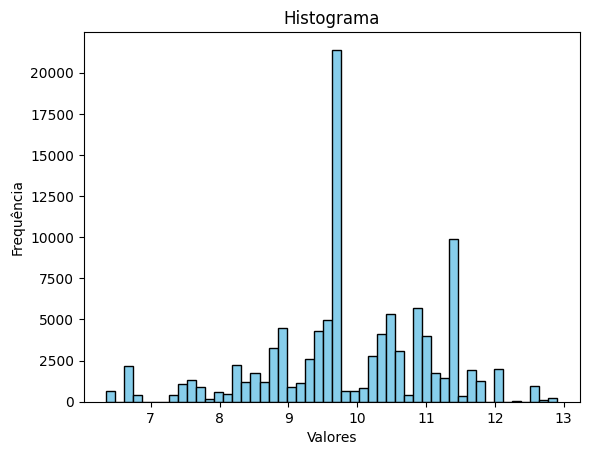

VAR_232


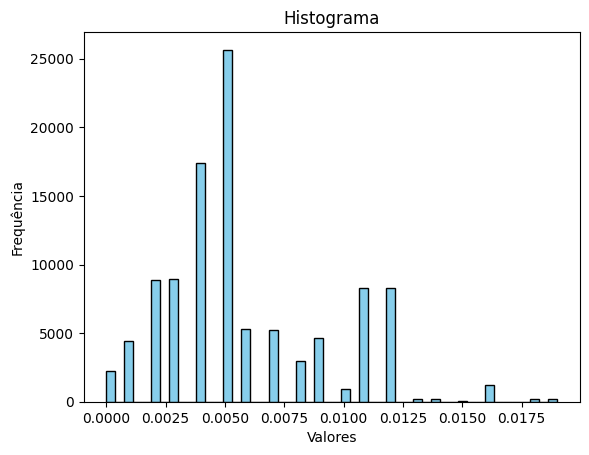

VAR_253


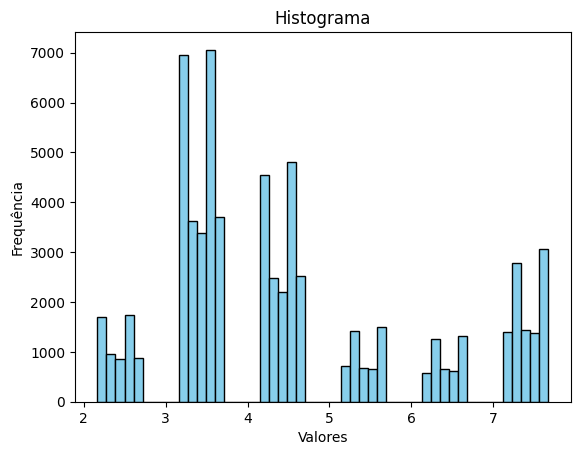

VAR_254


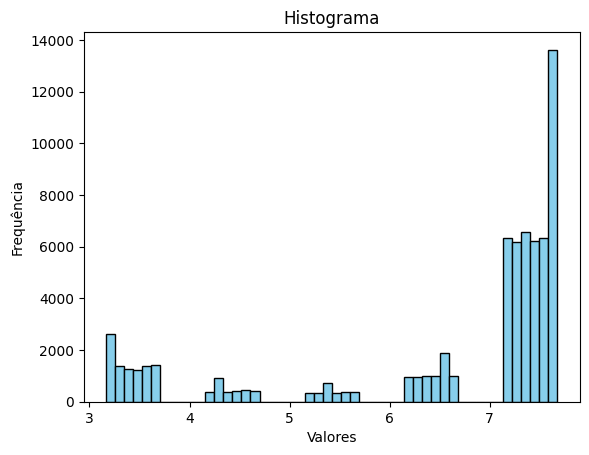

VAR_258


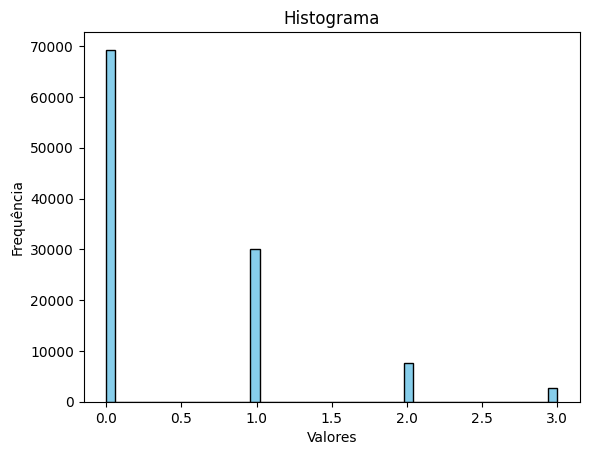

VAR_259


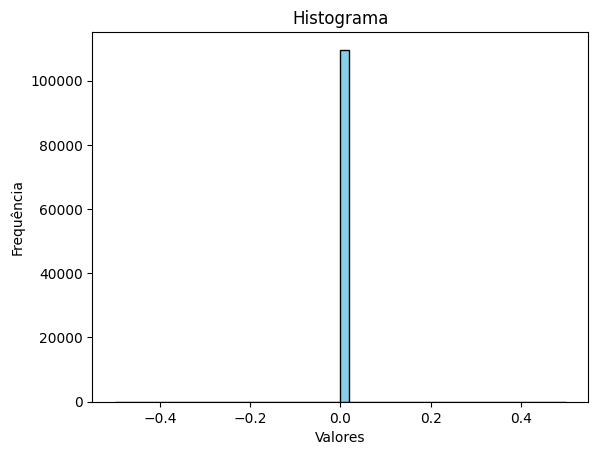

VAR_260


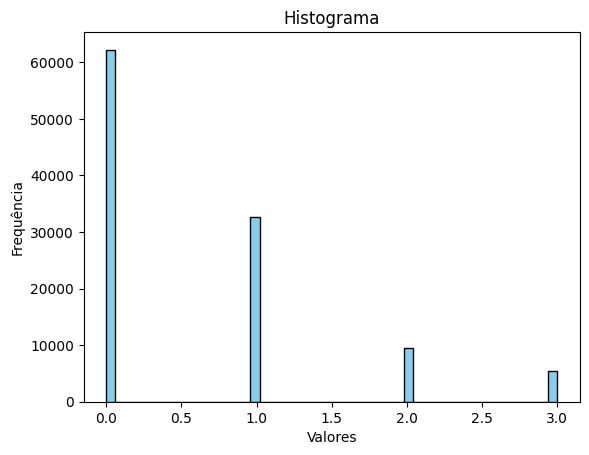

VAR_261


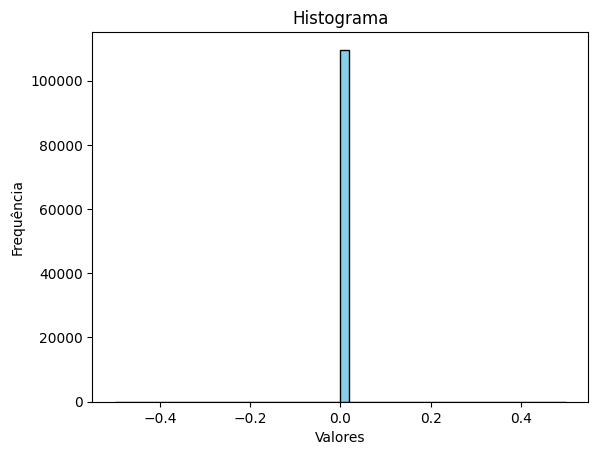

VAR_262


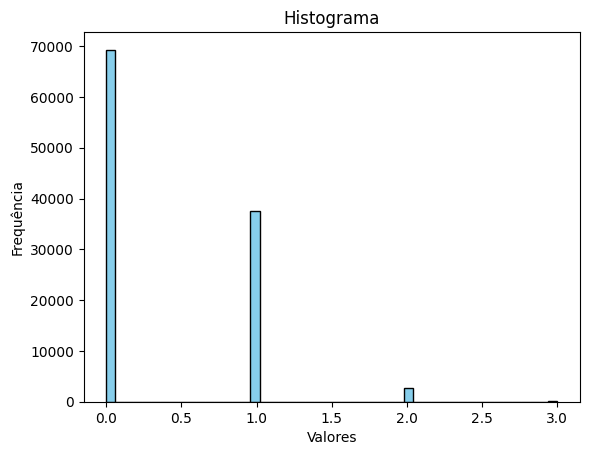

VAR_263


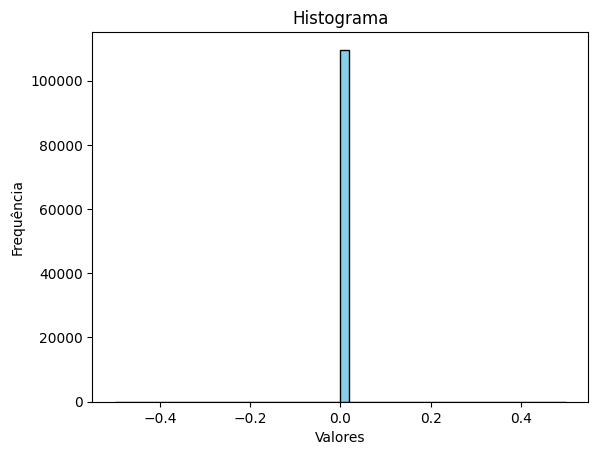

VAR_264


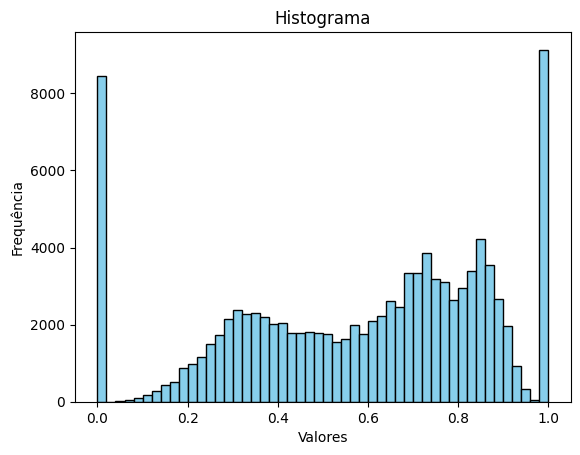

VAR_265


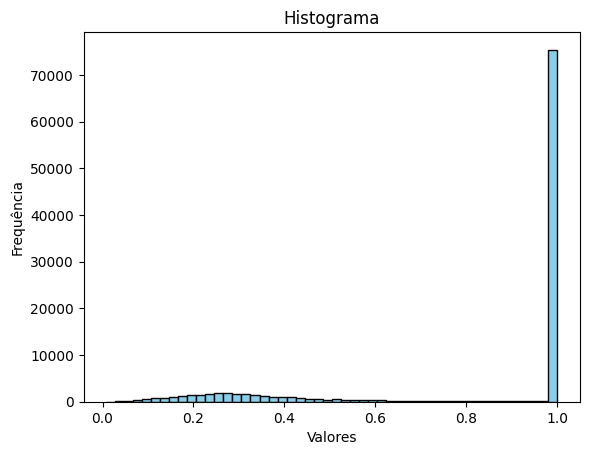

VAR_267


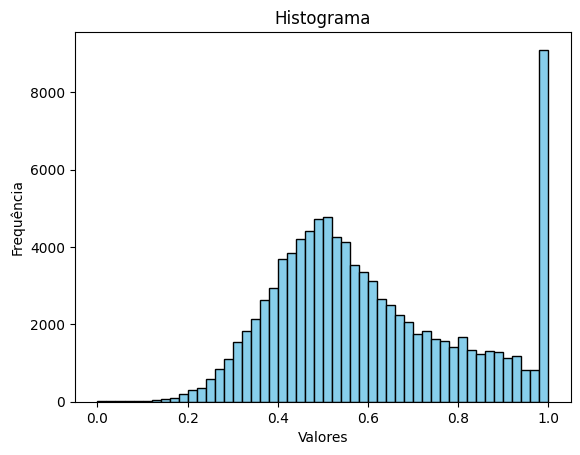

VAR_268


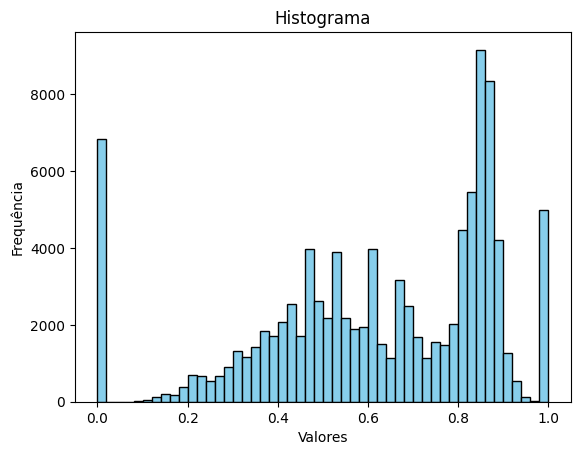

VAR_269


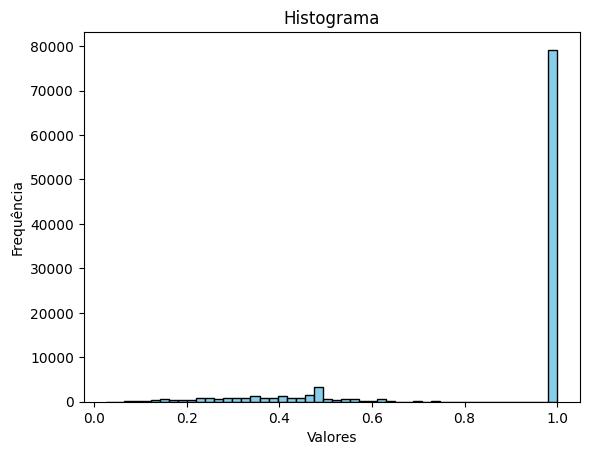

VAR_271


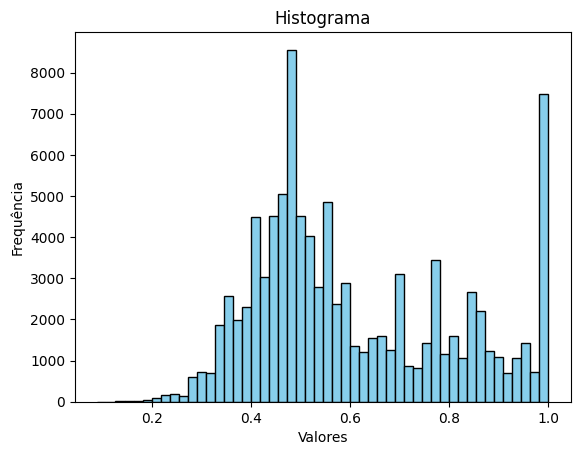

VAR_305


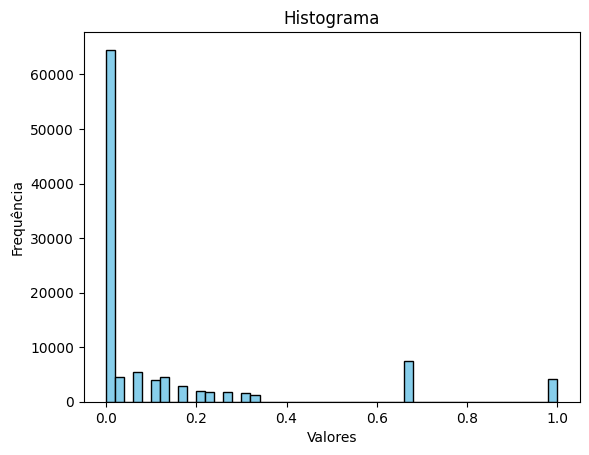

VAR_309


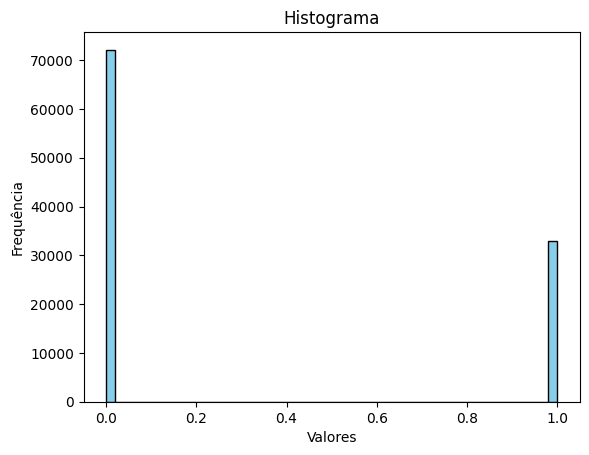

VAR_310


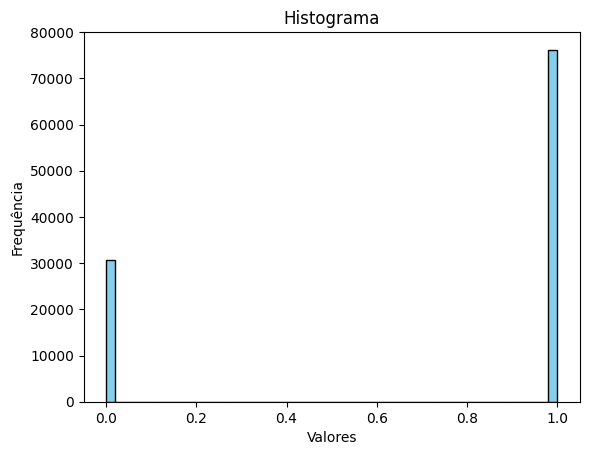

VAR_313


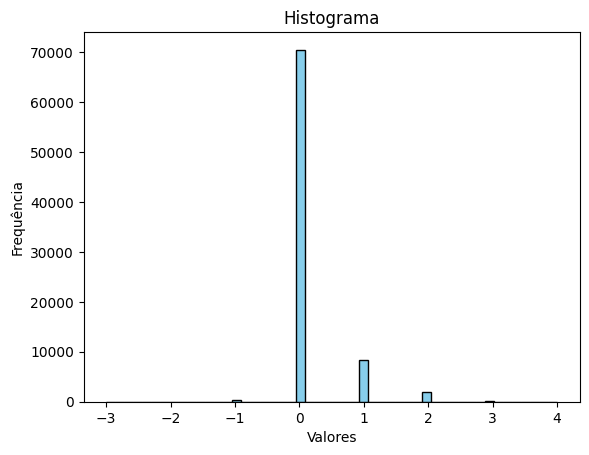

VAR_315


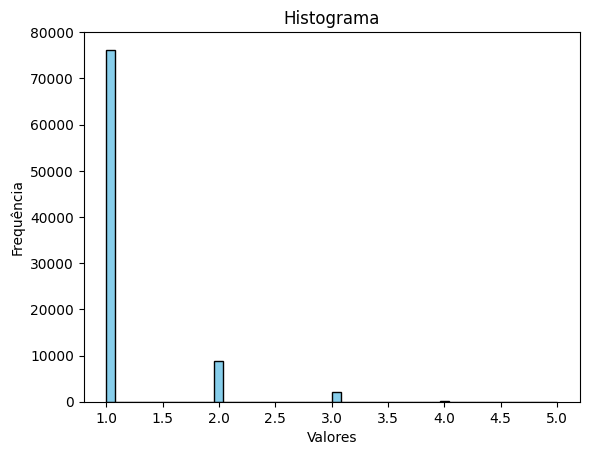

In [20]:
# Gráfico sem imputação dos dados faltantes

for i in num.columns:
    print(i)
    plot_histograma(i, num, label=None, bins=50)

In [21]:
# Variáveis numéricas, basicamente sem variabilidade serão desconsideradas

num = num.drop(columns=['VAR_140', 'VAR_141', 'VAR_145', 'VAR_154', 'VAR_155', 'VAR_156', 'VAR_162', 'VAR_163', 'VAR_183', 'VAR_199', 'VAR_215', 'VAR_259', 'VAR_261', 'VAR_263'])

In [22]:
num.shape

(109840, 123)

## Imputação via mediana e moda

In [23]:
num[['IDADE', 'VAR_5', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_12', 'VAR_15', 'VAR_17', 'VAR_18', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_32', 'VAR_33', 'VAR_34', 
'VAR_35', 'VAR_40', 'VAR_134', 'VAR_138', 'VAR_139', 'VAR_142', 'VAR_143', 'VAR_144', 'VAR_146', 'VAR_147', 'VAR_148', 'VAR_149', 'VAR_150', 'VAR_151', 'VAR_152', 
'VAR_153', 'VAR_157', 'VAR_158', 'VAR_159', 'VAR_160', 'VAR_161', 'VAR_165', 'VAR_166', 'VAR_167', 'VAR_168', 'VAR_169', 'VAR_173', 'VAR_174', 'VAR_175', 'VAR_176', 
'VAR_177',  'VAR_178', 'VAR_179', 'VAR_180', 'VAR_181', 'VAR_182', 'VAR_184', 'VAR_185', 'VAR_186', 'VAR_187', 'VAR_188', 'VAR_189', 'VAR_190', 'VAR_191', 'VAR_192', 
'VAR_193', 'VAR_194', 'VAR_195', 'VAR_196', 'VAR_197', 'VAR_198', 'VAR_200', 'VAR_201', 'VAR_202', 'VAR_203', 'VAR_204', 'VAR_205', 'VAR_206', 'VAR_207', 'VAR_208', 
'VAR_209', 'VAR_210', 'VAR_211', 'VAR_212', 'VAR_213', 'VAR_214', 'VAR_216', 'VAR_217', 'VAR_218', 'VAR_219', 'VAR_220', 'VAR_221', 'VAR_222', 'VAR_223', 'VAR_224', 
'VAR_225', 'VAR_226', 'VAR_227', 'VAR_228', 'VAR_229', 'VAR_230', 'VAR_231', 'VAR_232', 'VAR_253', 'VAR_254', 'VAR_264', 'VAR_265', 'VAR_267', 'VAR_268', 'VAR_269', 
'VAR_271', 'VAR_305']].shape

(109840, 108)

In [24]:
num1 = num[['IDADE', 'VAR_5', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_11', 'VAR_12', 'VAR_15', 'VAR_17', 'VAR_18', 'VAR_21', 'VAR_22', 'VAR_23', 'VAR_32', 'VAR_33', 'VAR_34', 
'VAR_35', 'VAR_40', 'VAR_134', 'VAR_138', 'VAR_139', 'VAR_142', 'VAR_143', 'VAR_144', 'VAR_146', 'VAR_147', 'VAR_148', 'VAR_149', 'VAR_150', 'VAR_151', 'VAR_152', 
'VAR_153', 'VAR_157', 'VAR_158', 'VAR_159', 'VAR_160', 'VAR_161', 'VAR_165', 'VAR_166', 'VAR_167', 'VAR_168', 'VAR_169', 'VAR_173', 'VAR_174', 'VAR_175', 'VAR_176', 
'VAR_177',  'VAR_178', 'VAR_179', 'VAR_180', 'VAR_181', 'VAR_182', 'VAR_184', 'VAR_185', 'VAR_186', 'VAR_187', 'VAR_188', 'VAR_189', 'VAR_190', 'VAR_191', 'VAR_192', 
'VAR_193', 'VAR_194', 'VAR_195', 'VAR_196', 'VAR_197', 'VAR_198', 'VAR_200', 'VAR_201', 'VAR_202', 'VAR_203', 'VAR_204', 'VAR_205', 'VAR_206', 'VAR_207', 'VAR_208', 
'VAR_209', 'VAR_210', 'VAR_211', 'VAR_212', 'VAR_213', 'VAR_214', 'VAR_216', 'VAR_217', 'VAR_218', 'VAR_219', 'VAR_220', 'VAR_221', 'VAR_222', 'VAR_223', 'VAR_224', 
'VAR_225', 'VAR_226', 'VAR_227', 'VAR_228', 'VAR_229', 'VAR_230', 'VAR_231', 'VAR_232', 'VAR_253', 'VAR_254', 'VAR_264', 'VAR_265', 'VAR_267', 'VAR_268', 'VAR_269', 
'VAR_271', 'VAR_305']]

In [25]:
num[['VAR_4', 'VAR_164', 'VAR_170', 'VAR_171', 'VAR_172', 'VAR_258', 'VAR_260', 'VAR_262', 'VAR_309', 'VAR_310', 'VAR_313', 'VAR_315']].shape

(109840, 12)

In [26]:
num2 = num[['VAR_4', 'VAR_164', 'VAR_170', 'VAR_171', 'VAR_172', 'VAR_258', 'VAR_260', 'VAR_262', 'VAR_309', 'VAR_310', 'VAR_313', 'VAR_315']]

In [ ]:
# dias_atraso, saldo_vencido, pagamento
108+12

120

In [27]:
imp = SimpleImputer(strategy='median')
imp.fit(num1)

SimpleImputer(strategy='median')

In [28]:
num1 = pd.DataFrame(imp.transform(num1), columns=num1.columns)
num1.head()

IDADE  VAR_5  VAR_7  VAR_8     VAR_9    VAR_11    VAR_12  VAR_15  VAR_17  \
0  25.173  0.051  0.203  0.182  1.333333  1.837035  2.727553   0.124   0.043   
1  23.767  0.101  0.203  0.182  1.083333  1.837035  2.727553   0.124   0.043   
2  47.268  0.057  0.626  0.708  1.500000  2.471023  7.406250   0.124   0.054   
3  52.789  0.247  0.203  0.182  0.833333  1.837035  2.727553   0.124   0.011   
4  39.162  0.744  0.203  0.193  1.583333  2.471023  2.867279   0.124   0.043   

   VAR_18  ...  VAR_232  VAR_253  VAR_254  VAR_264  VAR_265  VAR_267  VAR_268  \
0   0.024  ...    0.005    4.252    7.255    0.333    0.283    0.542    0.569   
1   0.024  ...    0.016    4.252    7.255    1.000    1.000    0.556    0.000   
2   0.000  ...    0.003    6.504    7.504    0.740    1.000    0.402    0.429   
3   0.024  ...    0.001    4.252    7.255    0.093    0.050    0.679    0.840   
4   0.000  ...    0.001    2.252    7.255    0.288    0.243    0.598    0.876   

   VAR_269  VAR_271  VAR_305  
0      1.0    0.816    0.233  
1      1.0    1.000    0.002  
2      1.0    0.921    0.005  
3      1.0    0.408    0.300  
4      1.0    0.411    0.333  

[5 rows x 108 columns]

In [29]:
imp = SimpleImputer(strategy='most_frequent')
imp.fit(num2)

SimpleImputer(strategy='most_frequent')

In [30]:
num2 = pd.DataFrame(imp.transform(num2), columns=num2.columns)
num2.head()

VAR_4  VAR_164  VAR_170  VAR_171  VAR_172  VAR_258  VAR_260  VAR_262  \
0    0.0      1.0      1.0      0.0      0.0      0.0      0.0      0.0   
1    0.0      1.0      2.0      0.0      0.0      0.0      0.0      0.0   
2    0.0      1.0      1.0      0.0      0.0      0.0      0.0      0.0   
3    0.0      1.0      1.0      1.0      0.0      0.0      0.0      0.0   
4    2.0      6.0      2.0      0.0      0.0      3.0      3.0      1.0   

   VAR_309  VAR_310  VAR_313  VAR_315  
0      0.0      1.0      0.0      1.0  
1      1.0      1.0      0.0      1.0  
2      1.0      1.0      0.0      1.0  
3      0.0      0.0      0.0      1.0  
4      0.0      0.0      0.0      1.0

In [31]:
num_new = pd.concat([num[['dias_atraso', 'saldo_vencido', 'pagamento']].reset_index(drop=True),
                     num1.reset_index(drop=True),
                     num2.reset_index(drop=True)], axis=1)
num_new.head()

dias_atraso  saldo_vencido  pagamento   IDADE  VAR_5  VAR_7  VAR_8  \
0           13         361.51     361.51  25.173  0.051  0.203  0.182   
1           11         873.51     873.51  23.767  0.101  0.203  0.182   
2           19        1242.81    1242.81  47.268  0.057  0.626  0.708   
3           17        2264.37    2264.37  52.789  0.247  0.203  0.182   
4           19        1110.75       0.00  39.162  0.744  0.203  0.193   

      VAR_9    VAR_11    VAR_12  ...  VAR_170  VAR_171  VAR_172  VAR_258  \
0  1.333333  1.837035  2.727553  ...      1.0      0.0      0.0      0.0   
1  1.083333  1.837035  2.727553  ...      2.0      0.0      0.0      0.0   
2  1.500000  2.471023  7.406250  ...      1.0      0.0      0.0      0.0   
3  0.833333  1.837035  2.727553  ...      1.0      1.0      0.0      0.0   
4  1.583333  2.471023  2.867279  ...      2.0      0.0      0.0      3.0   

   VAR_260  VAR_262  VAR_309  VAR_310  VAR_313  VAR_315  
0      0.0      0.0      0.0      1.0      0.0      1.0  
1      0.0      0.0      1.0      1.0      0.0      1.0  
2      0.0      0.0      1.0      1.0      0.0      1.0  
3      0.0      0.0      0.0      0.0      0.0      1.0  
4      3.0      1.0      0.0      0.0      0.0      1.0  

[5 rows x 123 columns]

In [32]:
# Calcula a correlação de spearman entre as variáveis numéricas
# Caso a correlação seja maior ou igual a 0.6, uma das variáveis será retirada

correl = Vars_Correl(num_new, num_new.columns, limiar=0.6)
correl.head()

Var1           Var2   Valores
0  dias_atraso  saldo_vencido  0.674508
1        IDADE        VAR_198 -0.693818
2        IDADE        VAR_200 -0.641215
3        IDADE        VAR_221 -0.607133
4        IDADE        VAR_223 -0.600833

In [33]:
lista_num_remove = list(set(correl['Var2'].unique()))
num_new = num_new.drop(columns=lista_num_remove)
num_new.head()

dias_atraso  pagamento   IDADE  VAR_5  VAR_7  VAR_8     VAR_9    VAR_11  \
0           13     361.51  25.173  0.051  0.203  0.182  1.333333  1.837035   
1           11     873.51  23.767  0.101  0.203  0.182  1.083333  1.837035   
2           19    1242.81  47.268  0.057  0.626  0.708  1.500000  2.471023   
3           17    2264.37  52.789  0.247  0.203  0.182  0.833333  1.837035   
4           19       0.00  39.162  0.744  0.203  0.193  1.583333  2.471023   

     VAR_12  VAR_15  ...  VAR_265  VAR_267  VAR_268  VAR_269  VAR_305  \
0  2.727553   0.124  ...    0.283    0.542    0.569      1.0    0.233   
1  2.727553   0.124  ...    1.000    0.556    0.000      1.0    0.002   
2  7.406250   0.124  ...    1.000    0.402    0.429      1.0    0.005   
3  2.727553   0.124  ...    0.050    0.679    0.840      1.0    0.300   
4  2.867279   0.124  ...    0.243    0.598    0.876      1.0    0.333   

   VAR_164  VAR_170  VAR_309  VAR_310  VAR_313  
0      1.0      1.0      0.0      1.0      0.0  
1      1.0      2.0      1.0      1.0      0.0  
2      1.0      1.0      1.0      1.0      0.0  
3      1.0      1.0      0.0      0.0      0.0  
4      6.0      2.0      0.0      0.0      0.0  

[5 rows x 56 columns]

## Imputação via MICE

In [34]:
# Seleciona uma amostra de 40% dos dados para a aplicação da imputação

df_amostral = num[num.columns.drop(['dias_atraso', 'saldo_vencido', 'pagamento'])].sample(frac=0.4, random_state=42)

In [35]:
imputer = IterativeImputer(max_iter=1, random_state=42)
imputer.fit(df_amostral)

/home/hugo/Documents/Git_GitHub/Estudo_Cobranca/vCobranca/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(max_iter=1, random_state=42)

In [36]:
# Salva o imputer

path = os.getcwd() + '/imputer.pkl'

with open(path, 'wb') as file:
    pickle.dump(imputer, file)

In [41]:
pd.DataFrame(imputer.transform(df_amostral), columns=df_amostral.columns).head()

IDADE     VAR_4     VAR_5     VAR_7  VAR_8     VAR_9    VAR_11    VAR_12  \
0  80.868  0.068667  0.037000  0.203000  0.131  0.416667  1.056213  1.067279   
1  29.827  1.000000  0.442000  0.210000  0.208  2.416667  2.471023  2.727553   
2  51.241  1.000000  0.311000  0.208000  0.205  0.583333  1.853473  1.705635   
3  32.811  0.000000  0.305384  0.173728  0.182  1.348454  2.333241  2.727553   
4  40.090  0.000000  0.132000  0.206000  0.204  0.500000  2.471023  3.023443   

   VAR_15  VAR_17  ...  VAR_265  VAR_267  VAR_268  VAR_269  VAR_271  VAR_305  \
0   0.124   0.151  ...     0.23    0.540    0.417    1.000    0.927    1.000   
1   0.373   0.033  ...     0.36    0.634    0.820    1.000    0.547    0.200   
2   0.249   0.033  ...     1.00    0.899    0.847    1.000    0.485    0.002   
3   0.124   0.000  ...     1.00    0.484    0.422    0.357    0.411    0.001   
4   0.249   0.043  ...     1.00    0.503    0.439    0.458    0.598    0.000   

   VAR_309  VAR_310   VAR_313   VAR_315  
0      0.0      0.0  0.000000  1.000000  
1      0.0      0.0  0.170700  1.178759  
2      1.0      1.0  0.000000  1.000000  
3      0.0      1.0  0.000000  1.000000  
4      0.0      1.0  0.110971  1.124413  

[5 rows x 120 columns]

In [ ]:
# path = os.getcwd() + '/imputer.pkl'

# with open(path, 'rb') as file:
#     imputer_load = pickle.load(file)

# Conclusão

- Algumas variáveis foram desconsideradas de início: 'id', 'documento', 'mes_pagamento', 'divida_restante', 'per_pago', 'GENERO' e 'target';

- Variáveis categóricas com dados faltantes foram preenchidas com 'Sem_Info';

- Variáveis categóricas com mais de 85% dos valores concentrados em um nível foram desconsideradas: VAR_2, VAR_42, VAR_44, VAR_45, VAR_46, VAR_47, VAR_48, VAR_50, VAR_51, VAR_52, VAR_53, VAR_55, VAR_56, VAR_57, VAR_113, VAR_256

- Foi feito o teste qui-quadrado para independência entre as variáveis categóricas e algumas delas foram desconsideradas, pois para um nível de significância de 5% a hipótese nula não há evidência suficientes para afirmar que as variáveis são não correlacionadas;

- Para as variáveis numéricas, os histogramas foram analisados (ainda sem imputação dos valores ausentes) e as variáveis sem variabilidade foram desconsideradas: 'VAR_140', 'VAR_141', 'VAR_145', 'VAR_154', 'VAR_155', 'VAR_156', 'VAR_162', 'VAR_163', 'VAR_183', 'VAR_199', 'VAR_215', 'VAR_259', 'VAR_261', 'VAR_263';

- Foram feitas duas aplicações de imputação: pela mediana e moda; com o uso do MICE (Multivariate Imputation by Chained-Equations). Depois dessa etapa, a análise de correlação de spearman foi realizada e aquelas que se mostratam correlacionadas foram desconsideradas.